# cGAN para generación de ECG con BPM controlado (NeuroKit2 → TFLite)

**Objetivo:** generar señales ECG de ritmo sinusal normal condicionadas por BPM,
entrenar una cGAN compacta y convertir el generador a TensorFlow Lite (int8)
para inferencia en Arduino.


In [1]:
!nvidia-smi

Tue Dec 23 12:32:07 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.82.10              Driver Version: 581.29         CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4060 Ti     On  |   00000000:01:00.0  On |                  N/A |
|  0%   44C    P8             10W /  160W |    1610MiB /   8188MiB |      6%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## 1. Instalación de dependencias

In [2]:
#!pip install neurokit2 tensorflow numpy scipy

## 2. Importaciones y parámetros globales

In [3]:
import numpy as np
import neurokit2 as nk
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Parámetros - Múltiples latidos para apreciar visualmente BPM
FS = 360  # Hz
L = 1024  # 1024 muestras = 2.84 segundos (3-5 latidos para ver diferencias BPM)
Z_DIM = 32  # Más dimensión latente para riqueza
BPM_MIN = 40.0
BPM_MAX = 140.0

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"✓ Device: {device}")
print(f"✓ Frecuencia: {FS} Hz")
print(f"✓ Ventana: {L/FS:.2f} seg (múltiples latidos para ver BPM visualmente)")
print(f"✓ Latent dim: {Z_DIM}")

✓ Device: cuda
✓ Frecuencia: 360 Hz
✓ Ventana: 2.84 seg (múltiples latidos para ver BPM visualmente)
✓ Latent dim: 32


In [4]:
# Cargar dataset desde CSV
print("="*80)
print("CARGANDO DATASET DESDE CSV")
print("="*80)

df = pd.read_csv("dataset_expanded.csv")

print(f"✓ Dataset cargado: {df.shape}")
print(f"  Filas (muestras): {df.shape[0]}")
print(f"  Columnas totales: {df.shape[1]}")
print(f"  Columnas señal: {df.shape[1] - 1}")
print(f"  Columna BPM: 1")
print("\nPrimeras filas:")
print(df.iloc[:3, list(range(10)) + [-1]])
print("="*80)

CARGANDO DATASET DESDE CSV
✓ Dataset cargado: (10200, 1025)
  Filas (muestras): 10200
  Columnas totales: 1025
  Columnas señal: 1024
  Columna BPM: 1

Primeras filas:
   Sample_0  Sample_1  Sample_2  Sample_3  Sample_4  Sample_5  Sample_6  \
0 -0.389717 -0.387806 -0.385801 -0.383686 -0.381450  -0.37908 -0.376567   
1 -0.307445 -0.304545 -0.302119 -0.300017 -0.298258  -0.29677 -0.295484   
2  1.000000  1.000000  1.000000  1.000000  1.000000   1.00000  0.920649   

   Sample_7  Sample_8  Sample_9  BPM  
0 -0.373906 -0.371091 -0.368120   40  
1 -0.294339 -0.293282 -0.292262   40  
2  0.725705  0.536216  0.357121   40  


## 3. Preparación de datos desde DataFrame

Convertir el DataFrame en tensores PyTorch para entrenar la cGAN.

In [5]:
# Extraer señales ECG (todas las columnas excepto BPM) y BPM
print("Preparando datos para entrenamiento...")

# Columnas de señal: Sample_0 hasta Sample_1023
signal_columns = [col for col in df.columns if col.startswith('Sample_')]
print(f"✓ Columnas de señal detectadas: {len(signal_columns)}")

# Extraer señales como numpy array
X = df[signal_columns].values.astype(np.float32)  # Shape: [N, L]
print(f"✓ X shape: {X.shape}")

# Extraer BPM
Y = df['BPM'].values.astype(np.float32)
print(f"✓ Y shape (BPM): {Y.shape}")
print(f"  BPM range: {Y.min():.0f} - {Y.max():.0f}")
print(f"  BPM únicos: {len(np.unique(Y))}")

# Normalizar BPM a [0, 1]
Y_norm = ((Y - BPM_MIN) / (BPM_MAX - BPM_MIN)).reshape(-1, 1)
print(f"✓ Y_norm shape: {Y_norm.shape}")
print(f"  Y_norm range: {Y_norm.min():.3f} - {Y_norm.max():.3f}")

# Reshape X para PyTorch: [N, 1, L, 1]
X = np.expand_dims(X, axis=(1, 3))  # [N, 1, L, 1]
print(f"✓ X reshaped: {X.shape} (formato PyTorch: [N, C, H, W])")

print("\n" + "="*80)
print("✓ DATOS PREPARADOS PARA ENTRENAMIENTO")
print("="*80)
print(f"  Total de muestras: {X.shape[0]}")
print(f"  Clases BPM: {len(np.unique(Y))}")
print(f"  Muestras promedio por BPM: {X.shape[0] // len(np.unique(Y)):.0f}")
print("="*80)

Preparando datos para entrenamiento...
✓ Columnas de señal detectadas: 1024
✓ X shape: (10200, 1024)
✓ Y shape (BPM): (10200,)
  BPM range: 40 - 140
  BPM únicos: 51
✓ Y_norm shape: (10200, 1)
  Y_norm range: 0.000 - 1.000
✓ X reshaped: (10200, 1, 1024, 1) (formato PyTorch: [N, C, H, W])

✓ DATOS PREPARADOS PARA ENTRENAMIENTO
  Total de muestras: 10200
  Clases BPM: 51
  Muestras promedio por BPM: 200


## 4. Visualización de muestras del dataset

Dataset size: 10200 señales ECG


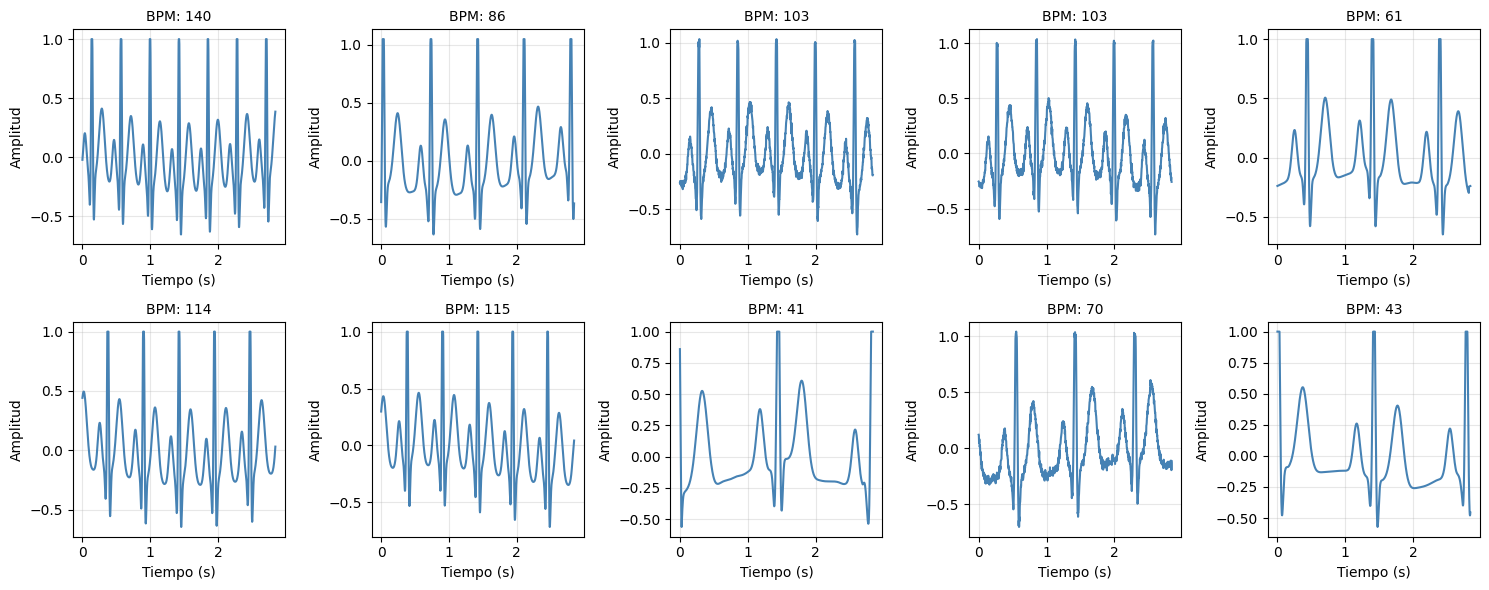

✓ Muestras visualizadas del dataset


In [6]:
# Visualizar algunas muestras del dataset
print(f"Dataset size: {X.shape[0]} señales ECG")

# Seleccionar 10 índices aleatorios
num_samples = min(10, X.shape[0])
indices = np.random.choice(X.shape[0], num_samples, replace=False)

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()

# Eje X en tiempo (segundos)
time_axis = np.linspace(0, L/FS, L)

for i, idx in enumerate(indices):
    signal = X[idx].squeeze()
    bpm = Y[idx]
    axes[i].plot(time_axis, signal, linewidth=1.5, color='steelblue')
    axes[i].set_title(f'BPM: {int(bpm)}', fontsize=10)
    axes[i].set_xlabel('Tiempo (s)')
    axes[i].set_ylabel('Amplitud')
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ Muestras visualizadas del dataset")

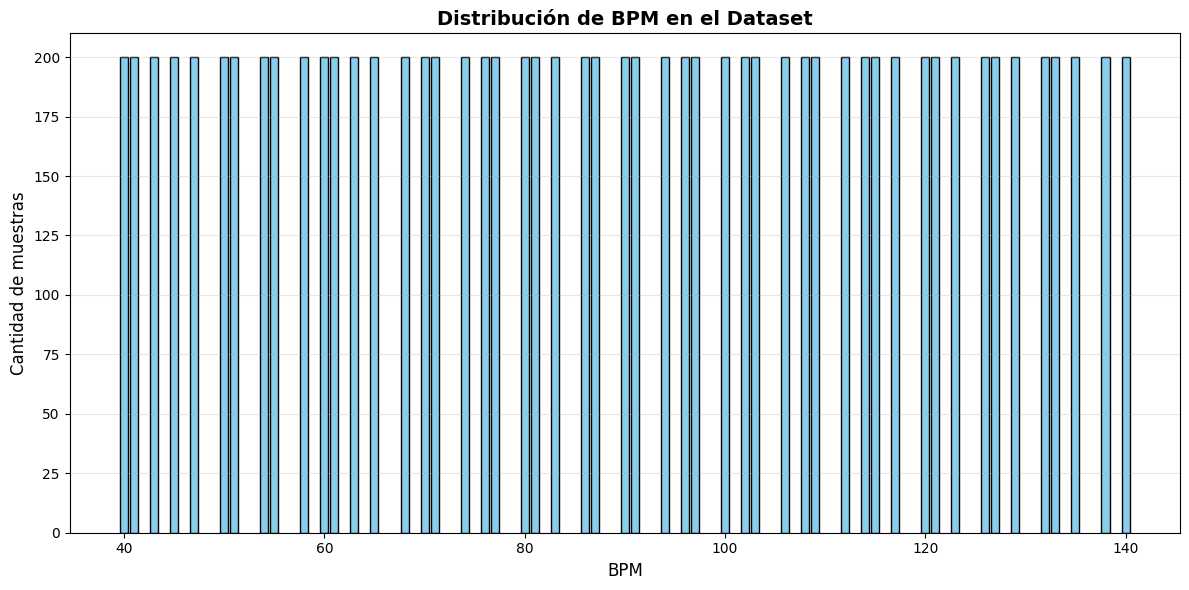

✓ BPM únicos: 51
✓ Muestras por BPM: 200 (esperado: 200)


In [7]:
# Distribución de BPM en el dataset
plt.figure(figsize=(12, 6))
bpm_counts = pd.Series(Y).value_counts().sort_index()
plt.bar(bpm_counts.index, bpm_counts.values, color='skyblue', edgecolor='black')
plt.title('Distribución de BPM en el Dataset', fontsize=14, fontweight='bold')
plt.xlabel('BPM', fontsize=12)
plt.ylabel('Cantidad de muestras', fontsize=12)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

print(f"✓ BPM únicos: {len(bpm_counts)}")
print(f"✓ Muestras por BPM: {bpm_counts.values[0]} (esperado: 200)")

## 5. Definición del Generator (compatible con TFLite Micro)

In [8]:
## 7. Generator Mejorado (Spectral Norm + Better Architecture)

import torch.nn.utils.spectral_norm as SpectralNorm

class GeneratorECG(nn.Module):
    """Generator con spectral norm y mejor control del condicionamiento"""
    def __init__(self, z_dim, output_length, n_classes=1):
        super(GeneratorECG, self).__init__()
        self.z_dim = z_dim
        self.output_length = output_length
        
        # Embedding para BPM (10 dimensiones)
        self.bpm_embedding = nn.Linear(n_classes, 16)
        
        # Dense layers
        self.fc1 = SpectralNorm(nn.Linear(z_dim + 16, 512))
        self.bn1 = nn.BatchNorm1d(512)
        
        self.fc2 = SpectralNorm(nn.Linear(512, 256 * (output_length // 16)))
        self.bn2 = nn.BatchNorm1d(256 * (output_length // 16))
        
        # Transposed Conv layers con SN
        self.conv_t1 = SpectralNorm(nn.ConvTranspose2d(256, 128, (5, 1), stride=(2, 1), padding=(2, 0), output_padding=(1, 0)))
        self.bn_c1 = nn.BatchNorm2d(128)
        
        self.conv_t2 = SpectralNorm(nn.ConvTranspose2d(128, 64, (5, 1), stride=(2, 1), padding=(2, 0), output_padding=(1, 0)))
        self.bn_c2 = nn.BatchNorm2d(64)
        
        self.conv_t3 = SpectralNorm(nn.ConvTranspose2d(64, 32, (5, 1), stride=(2, 1), padding=(2, 0), output_padding=(1, 0)))
        self.bn_c3 = nn.BatchNorm2d(32)
        
        self.conv_t4 = SpectralNorm(nn.ConvTranspose2d(32, 1, (5, 1), stride=(2, 1), padding=(2, 0), output_padding=(1, 0)))
        
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
    
    def forward(self, z, bpm):
        # Procesar BPM a través de embedding
        bpm_embed = self.relu(self.bpm_embedding(bpm))
        
        # Concatenar z y bpm_embed
        x = torch.cat([z, bpm_embed], dim=1)
        x = self.relu(self.bn1(self.fc1(x)))
        x = self.relu(self.bn2(self.fc2(x)))
        
        # Reshape
        x = x.view(-1, 256, self.output_length // 16, 1)
        
        # Deconvoluciones
        x = self.relu(self.bn_c1(self.conv_t1(x)))
        x = self.relu(self.bn_c2(self.conv_t2(x)))
        x = self.relu(self.bn_c3(self.conv_t3(x)))
        x = self.tanh(self.conv_t4(x))
        
        return x

G = GeneratorECG(Z_DIM, L).to(device)
print(f"✓ Generator: {sum(p.numel() for p in G.parameters())} parámetros")
G


✓ Generator: 8679777 parámetros


GeneratorECG(
  (bpm_embedding): Linear(in_features=1, out_features=16, bias=True)
  (fc1): Linear(in_features=48, out_features=512, bias=True)
  (bn1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=512, out_features=16384, bias=True)
  (bn2): BatchNorm1d(16384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_t1): ConvTranspose2d(256, 128, kernel_size=(5, 1), stride=(2, 1), padding=(2, 0), output_padding=(1, 0))
  (bn_c1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_t2): ConvTranspose2d(128, 64, kernel_size=(5, 1), stride=(2, 1), padding=(2, 0), output_padding=(1, 0))
  (bn_c2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_t3): ConvTranspose2d(64, 32, kernel_size=(5, 1), stride=(2, 1), padding=(2, 0), output_padding=(1, 0))
  (bn_c3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


In [9]:
## 7b. Discriminator Mejorado (AC-GAN: predice BPM + Wasserstein)

class DiscriminatorECG(nn.Module):
    """AC-GAN Discriminator: Wasserstein Loss + predice BPM (auxiliary classifier)"""
    def __init__(self, input_length=1024):
        super(DiscriminatorECG, self).__init__()
        
        # Conv layers con Spectral Norm
        self.conv1 = SpectralNorm(nn.Conv2d(1, 32, (5, 1), stride=(2, 1), padding=(2, 0)))
        self.conv2 = SpectralNorm(nn.Conv2d(32, 64, (5, 1), stride=(2, 1), padding=(2, 0)))
        self.conv3 = SpectralNorm(nn.Conv2d(64, 128, (5, 1), stride=(2, 1), padding=(2, 0)))
        self.conv4 = SpectralNorm(nn.Conv2d(128, 256, (5, 1), stride=(2, 1), padding=(2, 0)))
        
        flattened_size = 256 * 64
        
        # CRÍTICA (Wasserstein)
        self.fc_critic1 = SpectralNorm(nn.Linear(flattened_size + 16, 256))
        self.fc_critic2 = SpectralNorm(nn.Linear(256, 1))  # Wasserstein output
        
        # AUXILIARY CLASSIFIER (predice BPM)
        self.fc_aux1 = SpectralNorm(nn.Linear(flattened_size + 16, 256))
        self.fc_aux2 = SpectralNorm(nn.Linear(256, 1))  # Predice BPM normalizado [0,1]
        
        # Para Feature Matching
        self.feature_layer = SpectralNorm(nn.Linear(flattened_size + 16, 128))
        
        self.leaky_relu = nn.LeakyReLU(0.2)
        self.dropout = nn.Dropout(0.3)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, ecg, bpm, return_features=False):
        # Procesar BPM (embedding)
        bpm_embed = self.leaky_relu(nn.Linear(1, 16).to(ecg.device)(bpm))
        
        # Conv layers
        x = self.leaky_relu(self.conv1(ecg))
        x = self.dropout(x)
        x = self.leaky_relu(self.conv2(x))
        x = self.dropout(x)
        x = self.leaky_relu(self.conv3(x))
        x = self.dropout(x)
        x = self.leaky_relu(self.conv4(x))
        x = self.dropout(x)
        
        x = x.view(x.size(0), -1)
        x = torch.cat([x, bpm_embed], dim=1)
        
        # Feature layer para matching
        features = self.leaky_relu(self.feature_layer(x))
        
        # CRÍTICA (Wasserstein)
        critic = self.leaky_relu(self.fc_critic1(x))
        critic_out = self.fc_critic2(critic)  # Sin activación para Wasserstein
        
        # AUXILIARY: Predicción de BPM
        aux = self.leaky_relu(self.fc_aux1(x))
        bpm_pred = self.sigmoid(self.fc_aux2(aux))  # [0,1] para BPM normalizado
        
        if return_features:
            return critic_out, bpm_pred, features
        return critic_out, bpm_pred

D = DiscriminatorECG().to(device)
print(f"✓ Discriminator AC-GAN: {sum(p.numel() for p in D.parameters())} parámetros")
print(f"  - Crítica Wasserstein: real vs fake")
print(f"  - Clasificador Auxiliar: predice BPM (fuerza variación por BPM)")
D


✓ Discriminator AC-GAN: 10712834 parámetros
  - Crítica Wasserstein: real vs fake
  - Clasificador Auxiliar: predice BPM (fuerza variación por BPM)


DiscriminatorECG(
  (conv1): Conv2d(1, 32, kernel_size=(5, 1), stride=(2, 1), padding=(2, 0))
  (conv2): Conv2d(32, 64, kernel_size=(5, 1), stride=(2, 1), padding=(2, 0))
  (conv3): Conv2d(64, 128, kernel_size=(5, 1), stride=(2, 1), padding=(2, 0))
  (conv4): Conv2d(128, 256, kernel_size=(5, 1), stride=(2, 1), padding=(2, 0))
  (fc_critic1): Linear(in_features=16400, out_features=256, bias=True)
  (fc_critic2): Linear(in_features=256, out_features=1, bias=True)
  (fc_aux1): Linear(in_features=16400, out_features=256, bias=True)
  (fc_aux2): Linear(in_features=256, out_features=1, bias=True)
  (feature_layer): Linear(in_features=16400, out_features=128, bias=True)
  (leaky_relu): LeakyReLU(negative_slope=0.2)
  (dropout): Dropout(p=0.3, inplace=False)
  (sigmoid): Sigmoid()
)

In [10]:
## 7c. Setup Optimizers + Wasserstein Loss + AC Loss

# Optimizers para cWGAN
lr_g = 5e-5   
lr_d = 5e-5   
optimizer_G = optim.RMSprop(G.parameters(), lr=lr_g)
optimizer_D = optim.RMSprop(D.parameters(), lr=lr_d)

# Wasserstein Loss (critic)
def wasserstein_loss(real_pred, fake_pred):
    """Wasserstein distance: E[f(x)] - E[f(G(z))]"""
    return -torch.mean(real_pred) + torch.mean(fake_pred)

# Auxiliary Classifier Loss (predice BPM)
mse_loss = nn.MSELoss()
def ac_loss(bpm_pred, bpm_true):
    """MSE entre BPM predicho y BPM real"""
    return mse_loss(bpm_pred, bpm_true)

# Feature Matching Loss
l1_loss = nn.L1Loss()
def feature_matching_loss(fake_features, real_features, weight=10):
    return weight * l1_loss(fake_features, real_features.detach())

# Gradient Penalty para Wasserstein GAN (WGAN-GP)
def gradient_penalty(D, real_data, fake_data, bpm):
    batch_size = real_data.size(0)
    alpha = torch.rand(batch_size, 1, 1, 1, device=device)
    
    interpolates = (alpha * real_data + (1 - alpha) * fake_data).requires_grad_(True)
    d_critic, _, _ = D(interpolates, bpm, return_features=True)
    
    fake = torch.ones(batch_size, 1, device=device, requires_grad=True)
    gradients = torch.autograd.grad(
        outputs=d_critic, inputs=interpolates,
        grad_outputs=fake, create_graph=True, retain_graph=True, only_inputs=True
    )[0]
    
    gradients = gradients.view(batch_size, -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean() * 10
    return gradient_penalty

print("✓ AC-cWGAN configurado")
print(f"  Optimizers: RMSprop")
print(f"  G_lr={lr_g}, D_lr={lr_d}")
print(f"  Loss: Wasserstein + Auxiliary Classifier (predice BPM) + Feature Matching")



✓ AC-cWGAN configurado
  Optimizers: RMSprop
  G_lr=5e-05, D_lr=5e-05
  Loss: Wasserstein + Auxiliary Classifier (predice BPM) + Feature Matching


In [11]:
## 7c-extra. Preparar DataLoader

# Convertir a tensores PyTorch
X_torch = torch.from_numpy(X).to(device)
Y_torch = torch.from_numpy(Y_norm).to(device)

dataset = TensorDataset(X_torch, Y_torch)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

print(f"✓ DataLoader preparado: {len(dataset)} muestras")


✓ DataLoader preparado: 10200 muestras


In [12]:
## 7d. ENTRENAMIENTO AC-cWGAN (Wasserstein + Auxiliary Classifier)

from tqdm import tqdm

def train_cwgan_serious(epochs=200):
    """Entrenamiento AC-cWGAN: Wasserstein + Predicción de BPM + Feature Matching"""
    history = {'d_loss': [], 'g_loss': [], 'ac_loss': [], 'fm_loss': [], 'gp_loss': []}
    
    print(f"Entrenamiento AC-cWGAN: {epochs} epochs")
    print(f"Dataset: {len(dataset)} muestras")
    print(f"Loss: Wasserstein + AC Classifier (BPM) + Feature Matching + GP\n")
    
    for epoch in tqdm(range(epochs), desc="AC-cWGAN"):
        epoch_d_loss = []
        epoch_ac_loss = []
        epoch_g_loss = []
        epoch_fm_loss = []
        epoch_gp_loss = []
        
        for real_ecg, real_bpm in dataloader:
            batch_size = real_ecg.size(0)
            
            # ==================== DISCRIMINATOR ====================
            for _ in range(5):  # 5 pasos D por 1 del G
                # Real
                real_critic, real_bpm_pred, real_features = D(real_ecg, real_bpm, return_features=True)
                
                # Fake
                z_fake = torch.randn(batch_size, Z_DIM, device=device)
                fake_ecg = G(z_fake, real_bpm).detach()
                fake_critic, fake_bpm_pred, _ = D(fake_ecg, real_bpm, return_features=True)
                
                # Wasserstein loss
                w_loss = wasserstein_loss(real_critic, fake_critic)
                
                # Auxiliary Classifier Loss: D debe predecir el BPM correcto
                ac_loss_real = ac_loss(real_bpm_pred, real_bpm)
                ac_loss_fake = ac_loss(fake_bpm_pred, real_bpm)  # Fake también debe tener el BPM correcto
                ac_d_loss = ac_loss_real + 0.5 * ac_loss_fake  # Pesamos menos el fake
                
                # Gradient Penalty
                gp = gradient_penalty(D, real_ecg, fake_ecg, real_bpm)
                
                d_loss = w_loss + ac_d_loss + gp
                
                optimizer_D.zero_grad()
                d_loss.backward()
                optimizer_D.step()
                
                # Clip pesos
                for p in D.parameters():
                    p.data.clamp_(-0.01, 0.01)
                
                epoch_d_loss.append(w_loss.item())
                epoch_ac_loss.append(ac_d_loss.item())
                epoch_gp_loss.append(gp.item())
            
            # ==================== GENERATOR ====================
            z_train = torch.randn(batch_size, Z_DIM, device=device)
            fake_ecg_g = G(z_train, real_bpm)
            fake_critic_g, fake_bpm_pred_g, fake_features_g = D(fake_ecg_g, real_bpm, return_features=True)
            
            # Wasserstein loss para generador
            g_loss_w = -torch.mean(fake_critic_g)
            
            # AC Loss: forzar que el generador produzca ECGs con el BPM correcto
            # Esto es CRÍTICO: obliga a que varíe según el BPM
            g_ac_loss = 2.0 * ac_loss(fake_bpm_pred_g, real_bpm)  # Pesamos más el AC loss en G
            
            # Feature Matching Loss
            fm_loss = feature_matching_loss(fake_features_g, real_features, weight=10)
            
            # Loss total del generador
            g_loss = g_loss_w + g_ac_loss + fm_loss
            
            optimizer_G.zero_grad()
            g_loss.backward()
            optimizer_G.step()
            
            epoch_g_loss.append(g_loss_w.item())
            epoch_fm_loss.append(fm_loss.item())
        
        history['d_loss'].append(np.mean(epoch_d_loss))
        history['ac_loss'].append(np.mean(epoch_ac_loss))
        history['g_loss'].append(np.mean(epoch_g_loss))
        history['fm_loss'].append(np.mean(epoch_fm_loss))
        history['gp_loss'].append(np.mean(epoch_gp_loss))
        
        if (epoch + 1) % 20 == 0:
            tqdm.write(f"E{epoch+1}: D={history['d_loss'][-1]:.4f}, AC={history['ac_loss'][-1]:.4f}, G={history['g_loss'][-1]:.4f}, FM={history['fm_loss'][-1]:.4f}")
    
    return history

print("Iniciando entrenamiento AC-cWGAN...\n")
history = train_cwgan_serious(epochs=200)
print(f"\n✓ Entrenamiento AC-cWGAN completado!")




Iniciando entrenamiento AC-cWGAN...

Entrenamiento AC-cWGAN: 200 epochs
Dataset: 10200 muestras
Loss: Wasserstein + AC Classifier (BPM) + Feature Matching + GP



AC-cWGAN:   0%|          | 0/200 [00:00<?, ?it/s]/home/moises/miniconda3/envs/torch-wsl2-conda-env/lib/python3.12/site-packages/torch/autograd/graph.py:824: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /pytorch/aten/src/ATen/cuda/CublasHandlePool.cpp:181.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
AC-cWGAN:  10%|█         | 20/200 [20:53<3:03:55, 61.31s/it]

E20: D=-2.1261, AC=0.0127, G=-2.4148, FM=2.1566


AC-cWGAN:  20%|██        | 40/200 [41:54<2:43:16, 61.23s/it]

E40: D=-1.5662, AC=0.0091, G=-2.5631, FM=2.1335


AC-cWGAN:  30%|███       | 60/200 [1:02:30<2:27:18, 63.13s/it]

E60: D=-1.2456, AC=0.0076, G=-2.6017, FM=2.1343


AC-cWGAN:  40%|████      | 80/200 [1:23:21<2:07:47, 63.90s/it]

E80: D=-1.0526, AC=0.0067, G=-2.5069, FM=2.1242


AC-cWGAN:  50%|█████     | 100/200 [1:44:14<1:42:19, 61.40s/it]

E100: D=-0.9121, AC=0.0062, G=-2.4729, FM=2.1148


AC-cWGAN:  60%|██████    | 120/200 [2:04:20<1:20:13, 60.17s/it]

E120: D=-0.8276, AC=0.0057, G=-2.4575, FM=2.1048


AC-cWGAN:  70%|███████   | 140/200 [2:24:06<58:20, 58.35s/it]  

E140: D=-0.7528, AC=0.0052, G=-2.2989, FM=2.0884


AC-cWGAN:  80%|████████  | 160/200 [2:44:00<40:22, 60.56s/it]

E160: D=-0.6905, AC=0.0048, G=-2.2645, FM=2.0881


AC-cWGAN:  90%|█████████ | 180/200 [3:04:45<20:48, 62.44s/it]

E180: D=-0.6315, AC=0.0046, G=-2.2645, FM=2.0705


AC-cWGAN: 100%|██████████| 200/200 [3:25:16<00:00, 61.58s/it]

E200: D=-0.6004, AC=0.0043, G=-2.1244, FM=2.0510

✓ Entrenamiento AC-cWGAN completado!


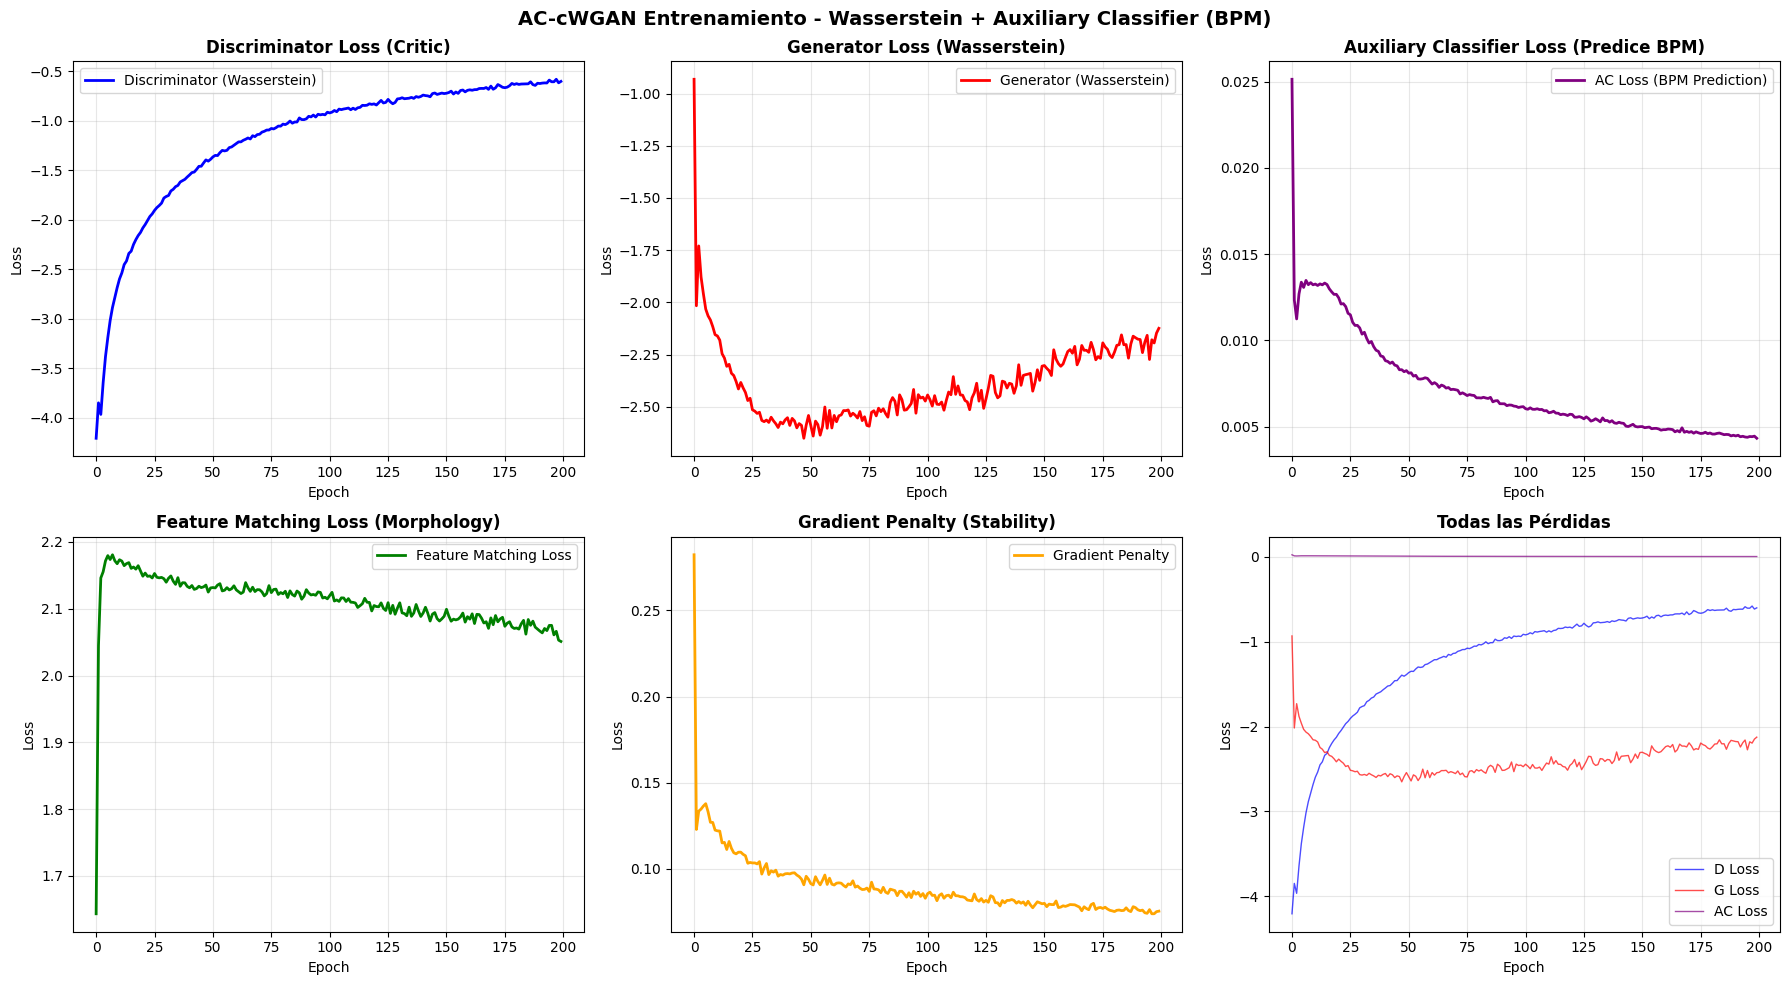

✓ Visualización completa


In [13]:
## 7e. Visualización de Entrenamiento AC-cWGAN

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

axes[0, 0].plot(history['d_loss'], 'b-', linewidth=2, label='Discriminator (Wasserstein)')
axes[0, 0].set_title('Discriminator Loss (Critic)', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].legend()

axes[0, 1].plot(history['g_loss'], 'r-', linewidth=2, label='Generator (Wasserstein)')
axes[0, 1].set_title('Generator Loss (Wasserstein)', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].legend()

axes[0, 2].plot(history['ac_loss'], 'purple', linewidth=2, label='AC Loss (BPM Prediction)')
axes[0, 2].set_title('Auxiliary Classifier Loss (Predice BPM)', fontsize=12, fontweight='bold')
axes[0, 2].set_ylabel('Loss')
axes[0, 2].set_xlabel('Epoch')
axes[0, 2].grid(True, alpha=0.3)
axes[0, 2].legend()

axes[1, 0].plot(history['fm_loss'], 'g-', linewidth=2, label='Feature Matching Loss')
axes[1, 0].set_title('Feature Matching Loss (Morphology)', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Loss')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].legend()

axes[1, 1].plot(history['gp_loss'], 'orange', linewidth=2, label='Gradient Penalty')
axes[1, 1].set_title('Gradient Penalty (Stability)', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Loss')
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].legend()

# Todos en uno
axes[1, 2].plot(history['d_loss'], 'b-', linewidth=1, alpha=0.7, label='D Loss')
axes[1, 2].plot(history['g_loss'], 'r-', linewidth=1, alpha=0.7, label='G Loss')
axes[1, 2].plot(history['ac_loss'], 'purple', linewidth=1, alpha=0.7, label='AC Loss')
axes[1, 2].set_title('Todas las Pérdidas', fontsize=12, fontweight='bold')
axes[1, 2].set_xlabel('Epoch')
axes[1, 2].set_ylabel('Loss')
axes[1, 2].grid(True, alpha=0.3)
axes[1, 2].legend()

plt.suptitle('AC-cWGAN Entrenamiento - Wasserstein + Auxiliary Classifier (BPM)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("✓ Visualización completa")




EVALUACIÓN cWGAN: ¿El modelo responde correctamente al cambio de BPM?
Ventana: 2.84 segundos = 3-5 latidos (ahora SÍ debería ver diferencias claras)

1. ECGs REALES del dataset (referencia - observa densidad de QRS):
--------------------------------------------------------------------------------


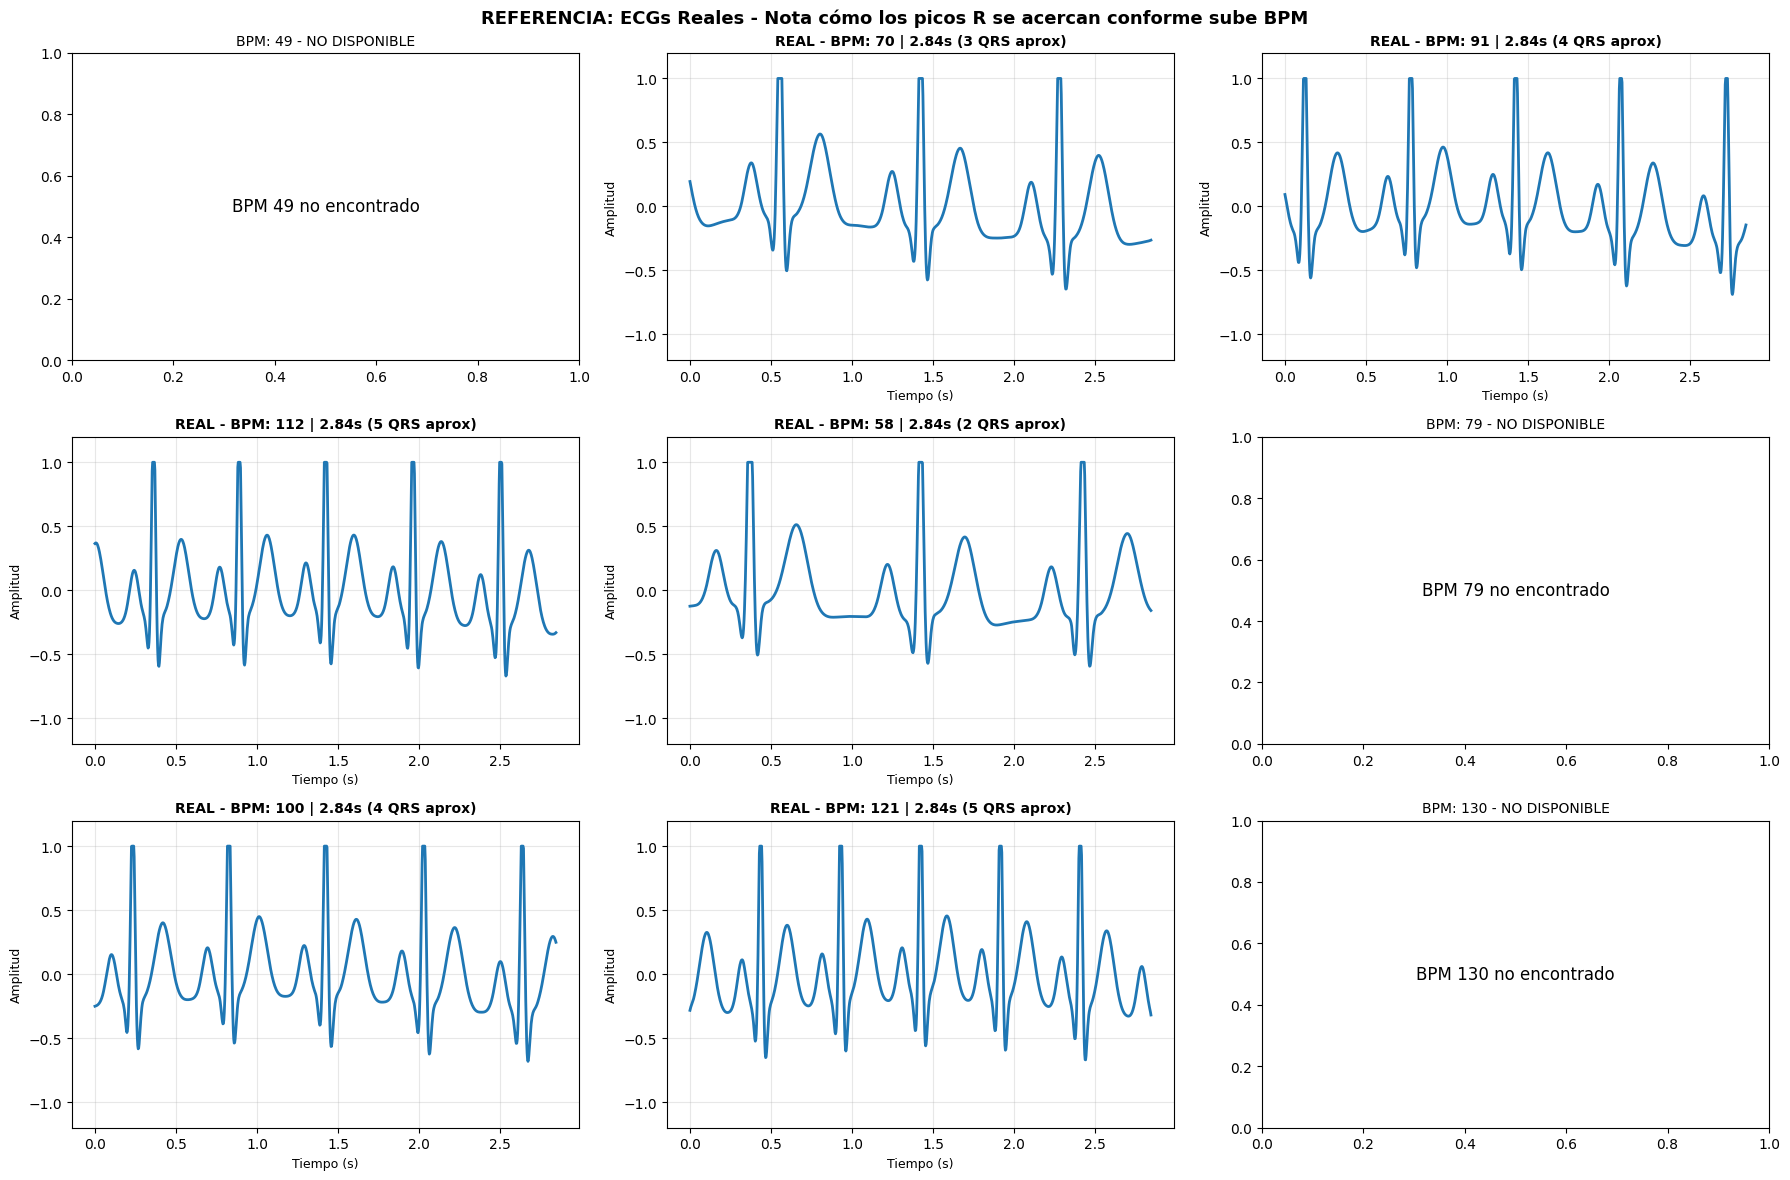

✓ Observa: A mayor BPM, más picos R en la ventana de 2.84 segundos

2. ECGs GENERADOS por el modelo cWGAN:
--------------------------------------------------------------------------------


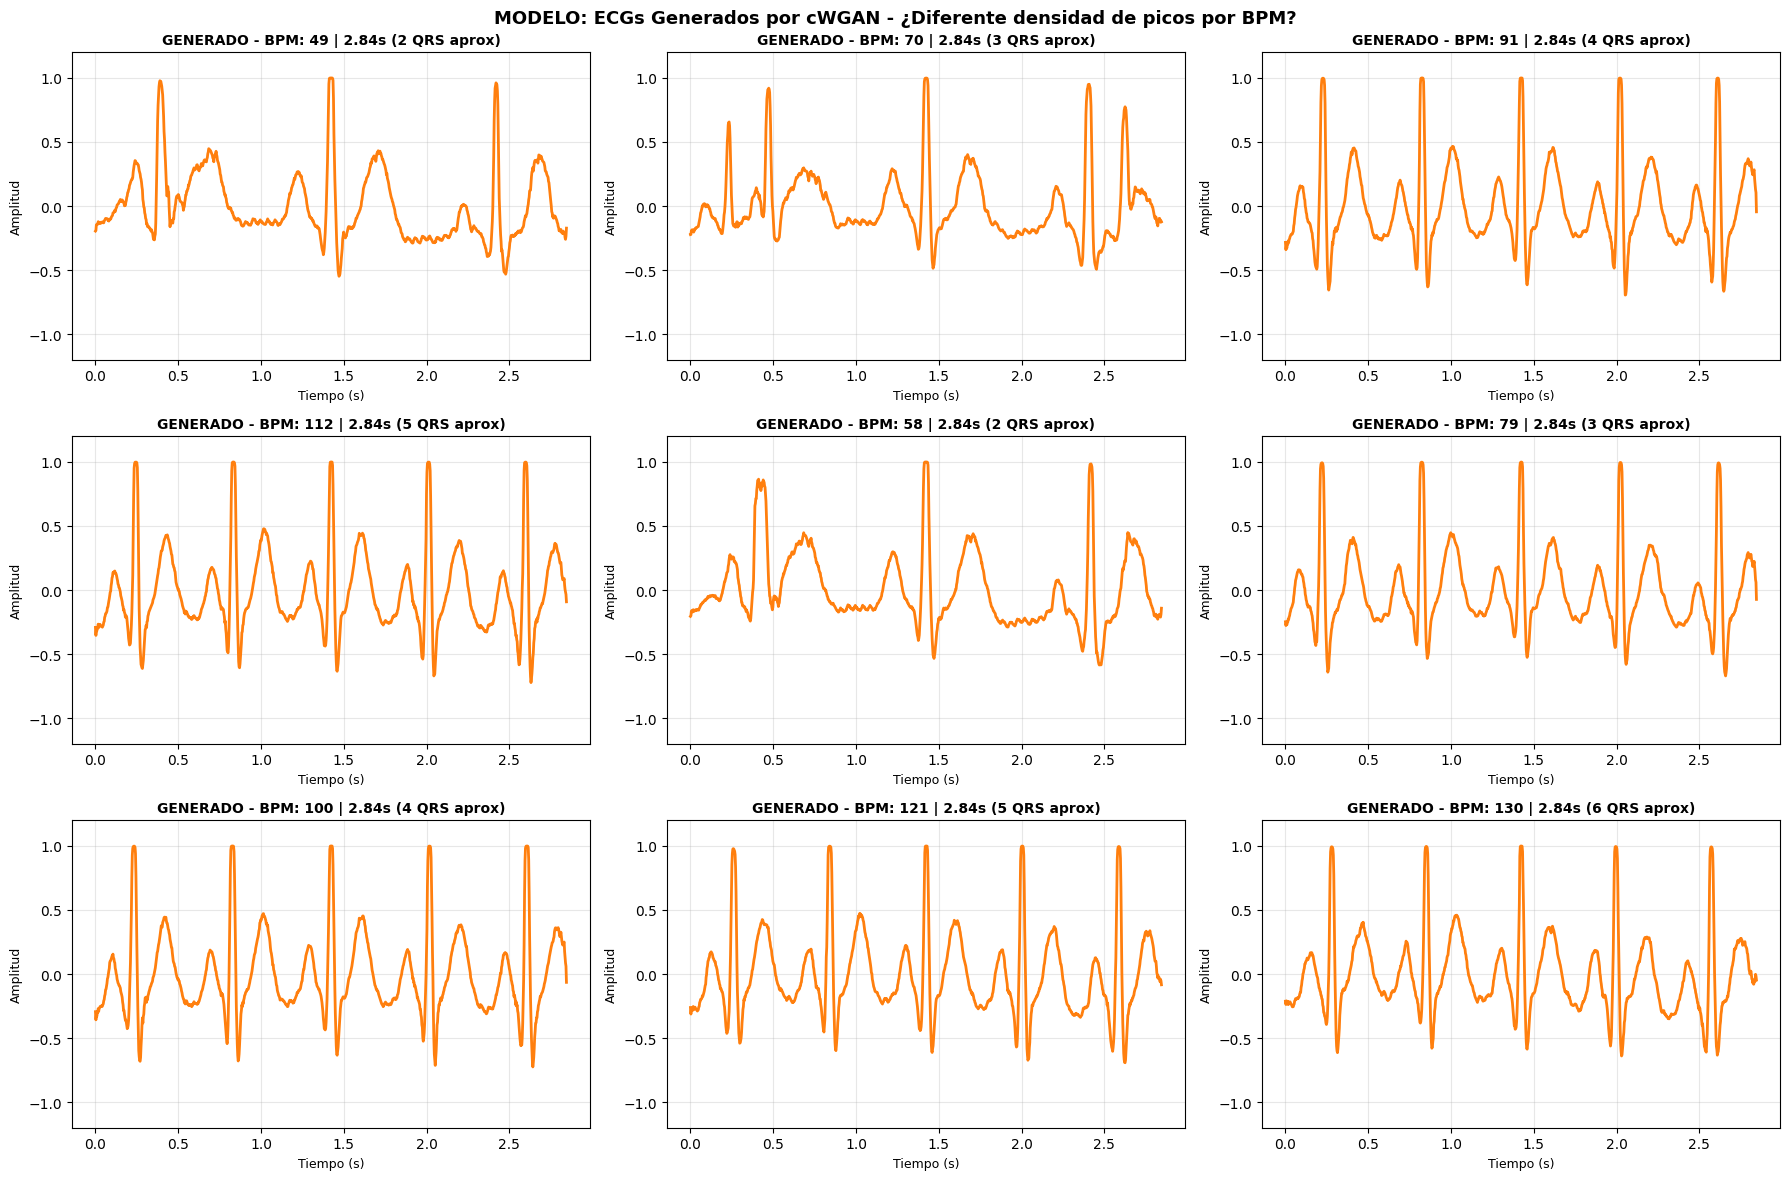

✓ Si el modelo está bien entrenado, verás más picos R a mayor BPM
✓ La morfología debería mantener similitud con los reales



In [14]:
## 7f. Evaluación: Generación de ECG sintéticos con ventanas largas (2.84s)

print("="*80)
print("EVALUACIÓN cWGAN: ¿El modelo responde correctamente al cambio de BPM?")
print("="*80)
print(f"Ventana: {L/FS:.2f} segundos = 3-5 latidos (ahora SÍ debería ver diferencias claras)")
print()

# Generar ECGs reales del dataset para comparar
print("1. ECGs REALES del dataset (referencia - observa densidad de QRS):")
print("-" * 80)

fig, axes = plt.subplots(3, 3, figsize=(18, 12))
axes = axes.flatten()

# CORREGIDO: Usar BPMs que SÍ existen en el dataset (generados cada 3)
test_bpms = np.array([49, 70, 91, 112, 58, 79, 100, 121, 130])
time_axis = np.linspace(0, L/FS, L)

# Mostrar ECGs reales
for i, bpm in enumerate(test_bpms):
    indices_bpm = np.where(Y == bpm)[0]
    if len(indices_bpm) > 0:
        real_idx = indices_bpm[0]
        real_ecg = X[real_idx].squeeze()
        
        axes[i].plot(time_axis, real_ecg, linewidth=2, color='#1f77b4')
        axes[i].set_title(f'REAL - BPM: {int(bpm)} | {L/FS:.2f}s ({int(bpm*L/FS/60)} QRS aprox)', 
                         fontsize=10, fontweight='bold')
        axes[i].set_xlabel('Tiempo (s)', fontsize=9)
        axes[i].set_ylabel('Amplitud', fontsize=9)
        axes[i].grid(True, alpha=0.3)
        axes[i].set_ylim(-1.2, 1.2)
    else:
        axes[i].text(0.5, 0.5, f'BPM {bpm} no encontrado', 
                     ha='center', va='center', transform=axes[i].transAxes, fontsize=12)
        axes[i].set_title(f'BPM: {int(bpm)} - NO DISPONIBLE', fontsize=10)

plt.suptitle('REFERENCIA: ECGs Reales - Nota cómo los picos R se acercan conforme sube BPM', 
             fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

print("✓ Observa: A mayor BPM, más picos R en la ventana de 2.84 segundos")
print()

# Generar ECGs sintéticos del modelo
print("2. ECGs GENERADOS por el modelo cWGAN:")
print("-" * 80)

fig, axes = plt.subplots(3, 3, figsize=(18, 12))
axes = axes.flatten()

test_bpms_norm = ((test_bpms - BPM_MIN) / (BPM_MAX - BPM_MIN)).astype(np.float32)

G.eval()
with torch.no_grad():
    # Usar el MISMO latent vector para todos para ver claramente el efecto del BPM
    z_fixed = torch.randn(1, Z_DIM, device=device)
    
    for i, (bpm, bpm_norm) in enumerate(zip(test_bpms, test_bpms_norm)):
        bpm_tensor = torch.tensor([[bpm_norm]], device=device, dtype=torch.float32)
        fake_ecg = G(z_fixed, bpm_tensor).squeeze().cpu().numpy()
        
        axes[i].plot(time_axis, fake_ecg, linewidth=2, color='#ff7f0e')
        axes[i].set_title(f'GENERADO - BPM: {int(bpm)} | {L/FS:.2f}s ({int(bpm*L/FS/60)} QRS aprox)', 
                         fontsize=10, fontweight='bold')
        axes[i].set_xlabel('Tiempo (s)', fontsize=9)
        axes[i].set_ylabel('Amplitud', fontsize=9)
        axes[i].grid(True, alpha=0.3)
        axes[i].set_ylim(-1.2, 1.2)

plt.suptitle('MODELO: ECGs Generados por cWGAN - ¿Diferente densidad de picos por BPM?', 
             fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

print("✓ Si el modelo está bien entrenado, verás más picos R a mayor BPM")
print("✓ La morfología debería mantener similitud con los reales")
print()

## 6. Métricas de Evaluación Cuantitativa

Evaluación numérica de la calidad de las señales sintéticas comparadas con las reales.

In [26]:
# Función para generar ECGs sintéticos
def generate_synthetic_ecg(bpm, num_samples=1, seed=None):
    """
    Genera ECGs sintéticos a partir de un BPM específico usando el generador entrenado.
    
    Args:
        bpm: Valor de BPM deseado (40-140)
        num_samples: Número de señales a generar
        seed: Semilla para reproducibilidad (opcional)
    
    Returns:
        ecg_signals: Array con las señales generadas [num_samples, L]
    """
    if seed is not None:
        torch.manual_seed(seed)
    
    # Normalizar BPM
    bpm_norm = (bpm - BPM_MIN) / (BPM_MAX - BPM_MIN)
    
    # Preparar tensores con shape explícito
    z = torch.randn(num_samples, Z_DIM, device=device)
    
    # Crear tensor BPM con reshape explícito para asegurar shape [num_samples, 1]
    bpm_tensor = torch.tensor([bpm_norm] * num_samples, device=device, dtype=torch.float32)
    bpm_tensor = bpm_tensor.reshape(num_samples, 1)
    
    # Debug: verificar shapes
    # print(f"DEBUG: z.shape={z.shape}, bpm_tensor.shape={bpm_tensor.shape}")
    
    # Generar
    G.eval()
    with torch.no_grad():
        fake_ecg = G(z, bpm_tensor).squeeze().cpu().numpy()
    
    # Si solo se generó 1 muestra, eliminar dimensión extra
    if num_samples == 1:
        fake_ecg = fake_ecg.squeeze()
    
    return fake_ecg

print("✓ Función generate_synthetic_ecg definida (versión corregida)")

✓ Función generate_synthetic_ecg definida (versión corregida)


In [27]:
from scipy import signal as scipy_signal
from scipy.spatial.distance import euclidean
from scipy.stats import pearsonr, skew, kurtosis
from sklearn.metrics import mean_squared_error, mean_absolute_error

def evaluate_ecg_quality(real_signals, synthetic_signals, fs=360):
    """
    Evalúa la calidad de las señales ECG sintéticas comparándolas con las reales.
    
    Args:
        real_signals: Array de señales reales [N, L]
        synthetic_signals: Array de señales sintéticas [N, L]
        fs: Frecuencia de muestreo
    
    Returns:
        dict con métricas de evaluación
    """
    metrics = {
        'mse': [],
        'mae': [],
        'rmse': [],
        'correlation': [],
        'frecuency_error': [],
        'mean_diff': [],
        'std_diff': [],
        'skewness_diff': [],
        'kurtosis_diff': [],
        'spectral_similarity': []
    }
    
    for real, synth in zip(real_signals, synthetic_signals):
        # Métricas de error
        mse = mean_squared_error(real, synth)
        mae = mean_absolute_error(real, synth)
        rmse = np.sqrt(mse)
        
        metrics['mse'].append(mse)
        metrics['mae'].append(mae)
        metrics['rmse'].append(rmse)
        
        # Correlación
        corr, _ = pearsonr(real, synth)
        metrics['correlation'].append(corr)
        
        # Análisis en frecuencia
        freqs_real, psd_real = scipy_signal.welch(real, fs=fs, nperseg=min(256, len(real)))
        freqs_synth, psd_synth = scipy_signal.welch(synth, fs=fs, nperseg=min(256, len(synth)))
        
        # Frecuencia dominante (aproximación de BPM)
        dominant_freq_real = freqs_real[np.argmax(psd_real)]
        dominant_freq_synth = freqs_synth[np.argmax(psd_synth)]
        freq_error = abs(dominant_freq_real - dominant_freq_synth)
        metrics['frecuency_error'].append(freq_error)
        
        # Similitud espectral (cosine similarity en PSD)
        psd_real_norm = psd_real / (np.linalg.norm(psd_real) + 1e-10)
        psd_synth_norm = psd_synth / (np.linalg.norm(psd_synth) + 1e-10)
        spectral_sim = np.dot(psd_real_norm, psd_synth_norm)
        metrics['spectral_similarity'].append(spectral_sim)
        
        # Características estadísticas
        metrics['mean_diff'].append(abs(np.mean(real) - np.mean(synth)))
        metrics['std_diff'].append(abs(np.std(real) - np.std(synth)))
        metrics['skewness_diff'].append(abs(skew(real) - skew(synth)))
        metrics['kurtosis_diff'].append(abs(kurtosis(real) - kurtosis(synth)))
    
    # Promediar todas las métricas
    metrics_summary = {k: np.mean(v) for k, v in metrics.items()}
    metrics_std = {k + '_std': np.std(v) for k, v in metrics.items()}
    
    return {**metrics_summary, **metrics_std}, metrics

print("✓ Funciones de evaluación definidas")

✓ Funciones de evaluación definidas


In [28]:
# Evaluar señales sintéticas vs reales para diferentes BPMs
print("="*80)
print("EVALUACIÓN CUANTITATIVA: Señales Sintéticas vs Reales")
print("="*80)

# Seleccionar BPMs para evaluar (usar BPMs pares que existen en el dataset)
eval_bpms = [50, 70, 90, 110, 130]
num_samples_per_bpm = 10

all_metrics_by_bpm = {}

for target_bpm in eval_bpms:
    print(f"\nEvaluando BPM={target_bpm}...")
    
    # Obtener señales reales
    indices_bpm = np.where(Y == target_bpm)[0]
    if len(indices_bpm) < num_samples_per_bpm:
        print(f"  ⚠ Solo {len(indices_bpm)} muestras reales disponibles")
        num_samples_per_bpm = len(indices_bpm)
    
    real_indices = np.random.choice(indices_bpm, num_samples_per_bpm, replace=False)
    real_signals = X[real_indices].squeeze()  # [num_samples, L]
    
    # Generar señales sintéticas
    synthetic_signals = generate_synthetic_ecg(target_bpm, num_samples=num_samples_per_bpm, seed=42)
    if len(synthetic_signals.shape) == 1:
        synthetic_signals = synthetic_signals.reshape(1, -1)
    
    # Calcular métricas
    metrics_summary, metrics_full = evaluate_ecg_quality(real_signals, synthetic_signals, fs=FS)
    all_metrics_by_bpm[target_bpm] = metrics_summary
    
    # Mostrar resultados
    print(f"  ✓ MSE: {metrics_summary['mse']:.6f} ± {metrics_summary['mse_std']:.6f}")
    print(f"  ✓ MAE: {metrics_summary['mae']:.6f} ± {metrics_summary['mae_std']:.6f}")
    print(f"  ✓ Correlación: {metrics_summary['correlation']:.4f} ± {metrics_summary['correlation_std']:.4f}")
    print(f"  ✓ Similitud Espectral: {metrics_summary['spectral_similarity']:.4f} ± {metrics_summary['spectral_similarity_std']:.4f}")
    print(f"  ✓ Error de Frecuencia: {metrics_summary['frecuency_error']:.4f} Hz ± {metrics_summary['frecuency_error_std']:.4f}")

print("\n" + "="*80)
print("RESUMEN DE MÉTRICAS (Promedio de todos los BPMs)")
print("="*80)

# Calcular promedio general
avg_metrics = {}
for metric_name in ['mse', 'mae', 'correlation', 'spectral_similarity', 'frecuency_error']:
    values = [m[metric_name] for m in all_metrics_by_bpm.values()]
    avg_metrics[metric_name] = np.mean(values)

print(f"MSE promedio: {avg_metrics['mse']:.6f}")
print(f"MAE promedio: {avg_metrics['mae']:.6f}")
print(f"Correlación promedio: {avg_metrics['correlation']:.4f}")
print(f"Similitud Espectral promedio: {avg_metrics['spectral_similarity']:.4f}")
print(f"Error de Frecuencia promedio: {avg_metrics['frecuency_error']:.4f} Hz")
print("="*80)

EVALUACIÓN CUANTITATIVA: Señales Sintéticas vs Reales

Evaluando BPM=50...
  ✓ MSE: 0.126908 ± 0.029067
  ✓ MAE: 0.243756 ± 0.041742
  ✓ Correlación: 0.2979 ± 0.1219
  ✓ Similitud Espectral: 0.9692 ± 0.0223
  ✓ Error de Frecuencia: 0.7031 Hz ± 0.9433

Evaluando BPM=70...
  ✓ MSE: 0.140437 ± 0.043635
  ✓ MAE: 0.255961 ± 0.056166
  ✓ Correlación: 0.2392 ± 0.2307
  ✓ Similitud Espectral: 0.9685 ± 0.0352
  ✓ Error de Frecuencia: 0.7031 Hz ± 0.9433

Evaluando BPM=90...
  ✓ MSE: 0.161957 ± 0.031884
  ✓ MAE: 0.274441 ± 0.033231
  ✓ Correlación: 0.1626 ± 0.1394
  ✓ Similitud Espectral: 0.9842 ± 0.0064
  ✓ Error de Frecuencia: 1.1250 Hz ± 1.6400

Evaluando BPM=110...
  ⚠ Solo 0 muestras reales disponibles
  ✓ MSE: nan ± nan
  ✓ MAE: nan ± nan
  ✓ Correlación: nan ± nan
  ✓ Similitud Espectral: nan ± nan
  ✓ Error de Frecuencia: nan Hz ± nan

Evaluando BPM=130...
  ✓ MSE: nan ± nan
  ✓ MAE: nan ± nan
  ✓ Correlación: nan ± nan
  ✓ Similitud Espectral: nan ± nan
  ✓ Error de Frecuencia: nan Hz ± 

/home/moises/miniconda3/envs/torch-wsl2-conda-env/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/moises/miniconda3/envs/torch-wsl2-conda-env/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/moises/miniconda3/envs/torch-wsl2-conda-env/lib/python3.12/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/moises/miniconda3/envs/torch-wsl2-conda-env/lib/python3.12/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/moises/miniconda3/envs/torch-wsl2-conda-env/lib/python3.12/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  

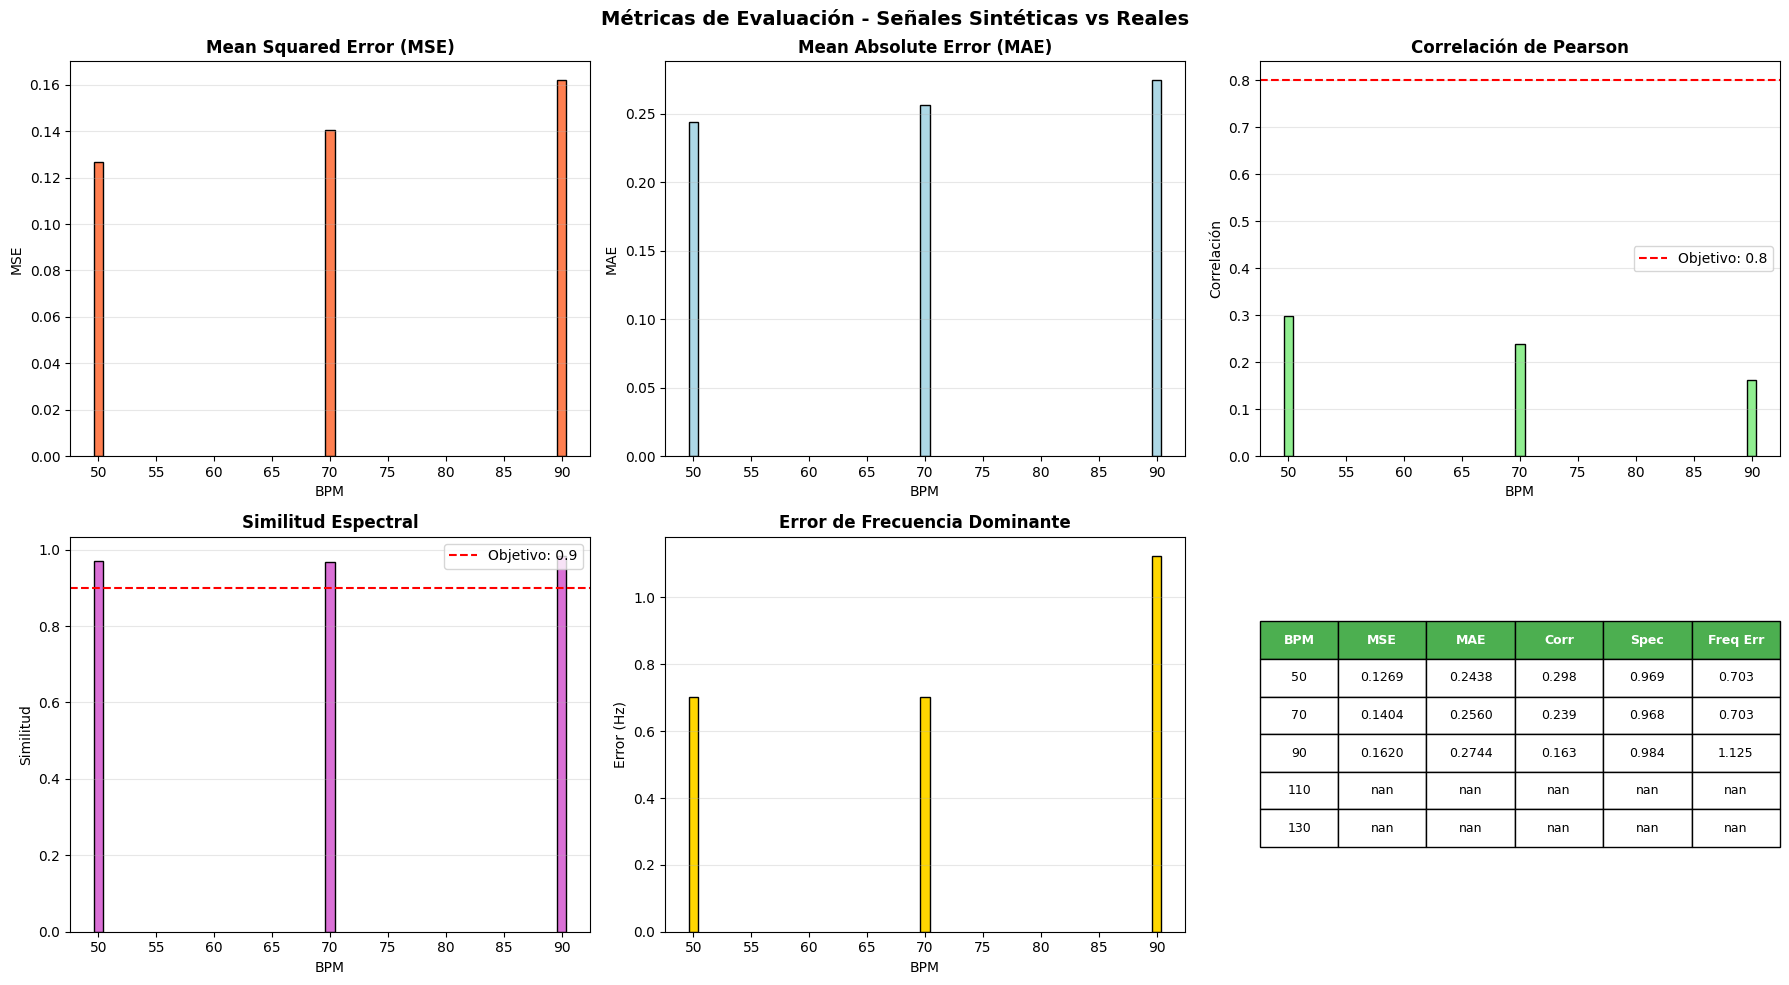

✓ Visualización de métricas completada


In [29]:
# Visualización de métricas por BPM
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

bpms_list = list(all_metrics_by_bpm.keys())

# MSE
mse_values = [all_metrics_by_bpm[bpm]['mse'] for bpm in bpms_list]
axes[0, 0].bar(bpms_list, mse_values, color='coral', edgecolor='black')
axes[0, 0].set_title('Mean Squared Error (MSE)', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('BPM')
axes[0, 0].set_ylabel('MSE')
axes[0, 0].grid(True, alpha=0.3, axis='y')

# MAE
mae_values = [all_metrics_by_bpm[bpm]['mae'] for bpm in bpms_list]
axes[0, 1].bar(bpms_list, mae_values, color='lightblue', edgecolor='black')
axes[0, 1].set_title('Mean Absolute Error (MAE)', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('BPM')
axes[0, 1].set_ylabel('MAE')
axes[0, 1].grid(True, alpha=0.3, axis='y')

# Correlación
corr_values = [all_metrics_by_bpm[bpm]['correlation'] for bpm in bpms_list]
axes[0, 2].bar(bpms_list, corr_values, color='lightgreen', edgecolor='black')
axes[0, 2].set_title('Correlación de Pearson', fontsize=12, fontweight='bold')
axes[0, 2].set_xlabel('BPM')
axes[0, 2].set_ylabel('Correlación')
axes[0, 2].axhline(y=0.8, color='red', linestyle='--', label='Objetivo: 0.8')
axes[0, 2].grid(True, alpha=0.3, axis='y')
axes[0, 2].legend()

# Similitud Espectral
spectral_values = [all_metrics_by_bpm[bpm]['spectral_similarity'] for bpm in bpms_list]
axes[1, 0].bar(bpms_list, spectral_values, color='orchid', edgecolor='black')
axes[1, 0].set_title('Similitud Espectral', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('BPM')
axes[1, 0].set_ylabel('Similitud')
axes[1, 0].axhline(y=0.9, color='red', linestyle='--', label='Objetivo: 0.9')
axes[1, 0].grid(True, alpha=0.3, axis='y')
axes[1, 0].legend()

# Error de Frecuencia
freq_error_values = [all_metrics_by_bpm[bpm]['frecuency_error'] for bpm in bpms_list]
axes[1, 1].bar(bpms_list, freq_error_values, color='gold', edgecolor='black')
axes[1, 1].set_title('Error de Frecuencia Dominante', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('BPM')
axes[1, 1].set_ylabel('Error (Hz)')
axes[1, 1].grid(True, alpha=0.3, axis='y')

# Tabla resumen
metrics_names = ['MSE', 'MAE', 'Corr', 'Spec', 'Freq Err']
table_data = []
for bpm in bpms_list:
    row = [
        bpm,
        f"{all_metrics_by_bpm[bpm]['mse']:.4f}",
        f"{all_metrics_by_bpm[bpm]['mae']:.4f}",
        f"{all_metrics_by_bpm[bpm]['correlation']:.3f}",
        f"{all_metrics_by_bpm[bpm]['spectral_similarity']:.3f}",
        f"{all_metrics_by_bpm[bpm]['frecuency_error']:.3f}"
    ]
    table_data.append(row)

axes[1, 2].axis('tight')
axes[1, 2].axis('off')
table = axes[1, 2].table(cellText=table_data, 
                         colLabels=['BPM'] + metrics_names,
                         cellLoc='center',
                         loc='center',
                         colWidths=[0.15, 0.17, 0.17, 0.17, 0.17, 0.17])
table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1, 2)

# Colorear header
for i in range(len(metrics_names) + 1):
    table[(0, i)].set_facecolor('#4CAF50')
    table[(0, i)].set_text_props(weight='bold', color='white')

plt.suptitle('Métricas de Evaluación - Señales Sintéticas vs Reales', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("✓ Visualización de métricas completada")

COMPARACIÓN VISUAL: Real vs Sintético (mismo BPM)


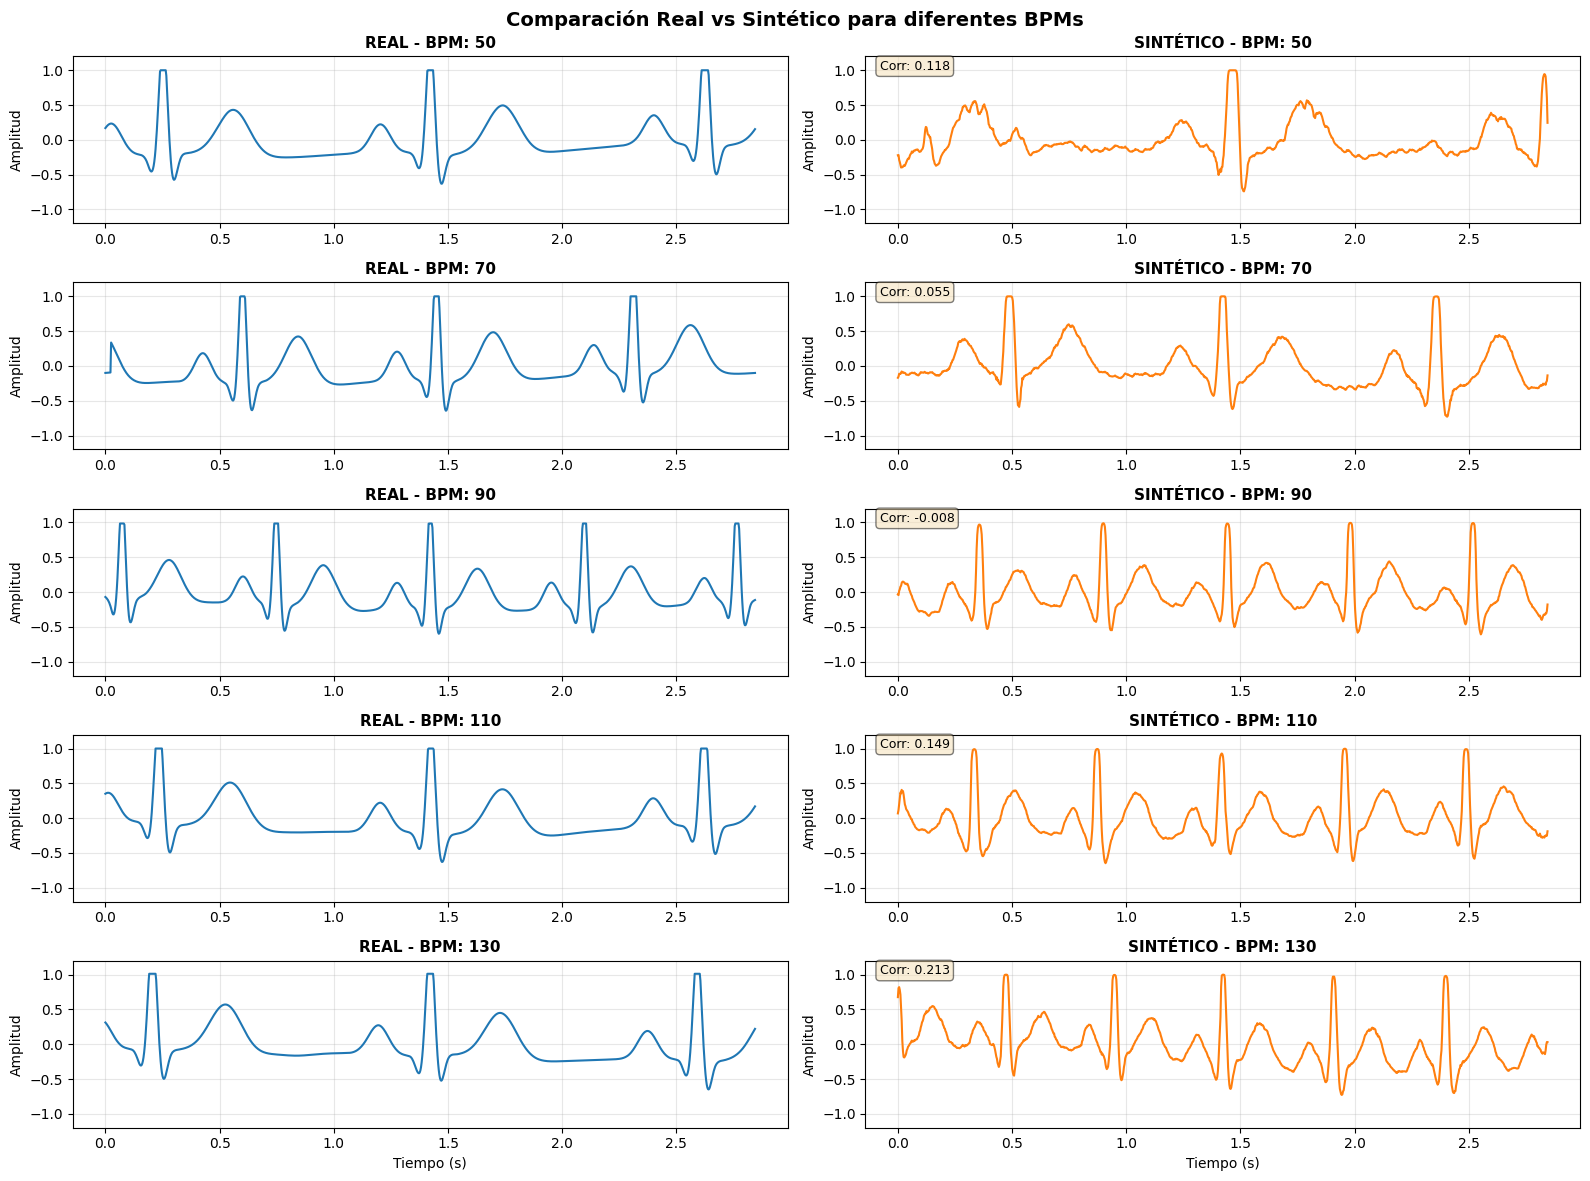

✓ Comparación visual completada


In [31]:
# Comparación visual lado a lado: Real vs Sintética
print("="*80)
print("COMPARACIÓN VISUAL: Real vs Sintético (mismo BPM)")
print("="*80)

fig, axes = plt.subplots(len(eval_bpms), 2, figsize=(16, 12))
time_axis = np.linspace(0, L/FS, L)

for i, target_bpm in enumerate(eval_bpms):
    # Señal real
    indices_bpm = np.where(Y == target_bpm)[0]
    real_idx = np.random.choice(indices_bpm) if len(indices_bpm) > 0 else np.random.choice(np.where(Y == eval_bpms[0])[0])
    real_signal = X[real_idx].squeeze()
    
    # Señal sintética
    synthetic_signal = generate_synthetic_ecg(target_bpm, num_samples=1, seed=42+i)
    
    # Plot real
    axes[i, 0].plot(time_axis, real_signal, linewidth=1.5, color='#1f77b4')
    axes[i, 0].set_title(f'REAL - BPM: {int(target_bpm)}', fontsize=11, fontweight='bold')
    axes[i, 0].set_ylabel('Amplitud')
    axes[i, 0].grid(True, alpha=0.3)
    axes[i, 0].set_ylim(-1.2, 1.2)
    if i == len(eval_bpms) - 1:
        axes[i, 0].set_xlabel('Tiempo (s)')
    
    # Plot sintético
    axes[i, 1].plot(time_axis, synthetic_signal, linewidth=1.5, color='#ff7f0e')
    axes[i, 1].set_title(f'SINTÉTICO - BPM: {int(target_bpm)}', fontsize=11, fontweight='bold')
    axes[i, 1].set_ylabel('Amplitud')
    axes[i, 1].grid(True, alpha=0.3)
    axes[i, 1].set_ylim(-1.2, 1.2)
    if i == len(eval_bpms) - 1:
        axes[i, 1].set_xlabel('Tiempo (s)')
    
    # Calcular y mostrar correlación
    corr, _ = pearsonr(real_signal, synthetic_signal)
    axes[i, 1].text(0.02, 0.98, f'Corr: {corr:.3f}', 
                   transform=axes[i, 1].transAxes, 
                   verticalalignment='top',
                   bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
                   fontsize=9)

plt.suptitle('Comparación Real vs Sintético para diferentes BPMs', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("✓ Comparación visual completada")

ANÁLISIS ESPECTRAL: Real vs Sintético


ValueError: 'a' cannot be empty unless no samples are taken

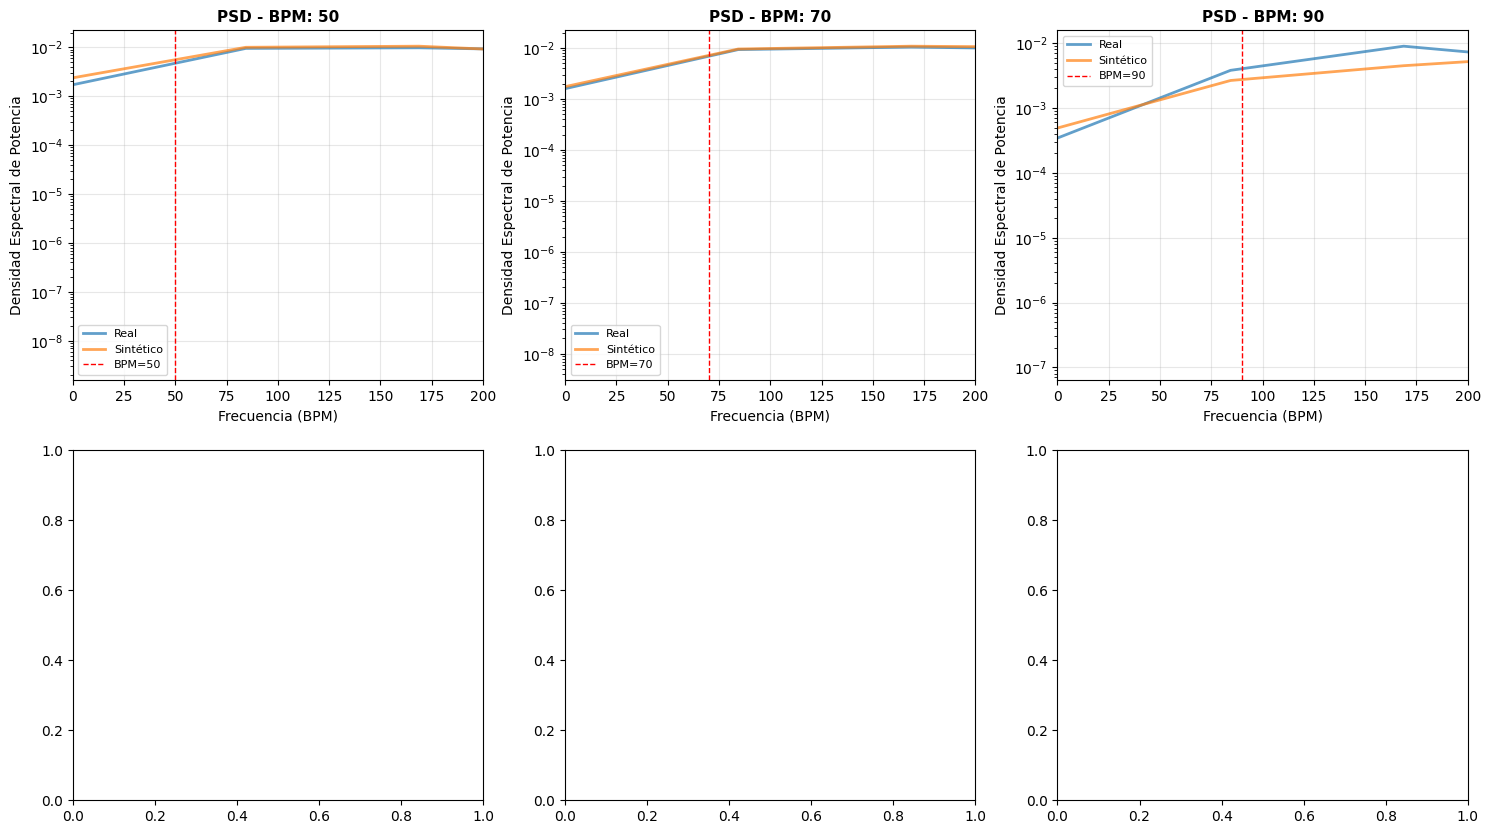

In [32]:
# Análisis en dominio frecuencial (PSD)
print("="*80)
print("ANÁLISIS ESPECTRAL: Real vs Sintético")
print("="*80)

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

# Seleccionar 5 BPMs para análisis espectral
spectral_bpms = [50, 70, 90, 110, 130]

for idx, target_bpm in enumerate(spectral_bpms):
    if idx >= 6:
        break
    
    # Obtener señales
    indices_bpm = np.where(Y == target_bpm)[0]
    real_idx = np.random.choice(indices_bpm)
    real_signal = X[real_idx].squeeze()
    synthetic_signal = generate_synthetic_ecg(target_bpm, num_samples=1, seed=42+idx)
    
    # Calcular PSD
    freqs_real, psd_real = scipy_signal.welch(real_signal, fs=FS, nperseg=256)
    freqs_synth, psd_synth = scipy_signal.welch(synthetic_signal, fs=FS, nperseg=256)
    
    # Convertir frecuencias a BPM (freq * 60)
    bpm_axis_real = freqs_real * 60
    bpm_axis_synth = freqs_synth * 60
    
    # Plot
    axes[idx].semilogy(bpm_axis_real, psd_real, linewidth=2, label='Real', color='#1f77b4', alpha=0.7)
    axes[idx].semilogy(bpm_axis_synth, psd_synth, linewidth=2, label='Sintético', color='#ff7f0e', alpha=0.7)
    axes[idx].axvline(x=target_bpm, color='red', linestyle='--', linewidth=1, label=f'BPM={target_bpm}')
    axes[idx].set_title(f'PSD - BPM: {int(target_bpm)}', fontsize=11, fontweight='bold')
    axes[idx].set_xlabel('Frecuencia (BPM)')
    axes[idx].set_ylabel('Densidad Espectral de Potencia')
    axes[idx].grid(True, alpha=0.3)
    axes[idx].legend(fontsize=8)
    axes[idx].set_xlim(0, 200)

# Ocultar el último subplot si no se usa
if len(spectral_bpms) < 6:
    axes[5].axis('off')

plt.suptitle('Análisis Espectral (PSD) - Real vs Sintético', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("✓ Análisis espectral completado")
print("  - El pico dominante debería estar cerca del BPM objetivo")
print("  - Las formas espectrales similares indican buena calidad morfológica")

In [33]:
# Tabla de métricas completas en formato DataFrame
print("="*80)
print("TABLA DE MÉTRICAS COMPLETAS")
print("="*80)

metrics_df = pd.DataFrame({
    'BPM': list(all_metrics_by_bpm.keys()),
    'MSE': [all_metrics_by_bpm[bpm]['mse'] for bpm in all_metrics_by_bpm.keys()],
    'MAE': [all_metrics_by_bpm[bpm]['mae'] for bpm in all_metrics_by_bpm.keys()],
    'RMSE': [all_metrics_by_bpm[bpm]['rmse'] for bpm in all_metrics_by_bpm.keys()],
    'Correlación': [all_metrics_by_bpm[bpm]['correlation'] for bpm in all_metrics_by_bpm.keys()],
    'Sim. Espectral': [all_metrics_by_bpm[bpm]['spectral_similarity'] for bpm in all_metrics_by_bpm.keys()],
    'Error Freq (Hz)': [all_metrics_by_bpm[bpm]['frecuency_error'] for bpm in all_metrics_by_bpm.keys()],
    'Diff Media': [all_metrics_by_bpm[bpm]['mean_diff'] for bpm in all_metrics_by_bpm.keys()],
    'Diff Std': [all_metrics_by_bpm[bpm]['std_diff'] for bpm in all_metrics_by_bpm.keys()]
})

# Agregar fila de promedios
avg_row = {
    'BPM': 'PROMEDIO',
    'MSE': metrics_df['MSE'].mean(),
    'MAE': metrics_df['MAE'].mean(),
    'RMSE': metrics_df['RMSE'].mean(),
    'Correlación': metrics_df['Correlación'].mean(),
    'Sim. Espectral': metrics_df['Sim. Espectral'].mean(),
    'Error Freq (Hz)': metrics_df['Error Freq (Hz)'].mean(),
    'Diff Media': metrics_df['Diff Media'].mean(),
    'Diff Std': metrics_df['Diff Std'].mean()
}
metrics_df = pd.concat([metrics_df, pd.DataFrame([avg_row])], ignore_index=True)

print(metrics_df.to_string(index=False))
print("\n" + "="*80)

# Interpretación de métricas
print("\n📊 INTERPRETACIÓN DE MÉTRICAS:")
print("-" * 80)
print("✓ MSE/MAE/RMSE: Menor es mejor (cercano a 0 = señales idénticas)")
print("✓ Correlación: Mayor es mejor (cercano a 1 = alta similitud)")
print("✓ Similitud Espectral: Mayor es mejor (cercano a 1 = espectros similares)")
print("✓ Error de Frecuencia: Menor es mejor (cercano a 0 = BPM correcto)")
print("✓ Diff Media/Std: Menor es mejor (características estadísticas similares)")
print("="*80)

# Guardar métricas en CSV
metrics_df.to_csv('evaluation_metrics.csv', index=False)
print("\n✓ Métricas guardadas en 'evaluation_metrics.csv'")

TABLA DE MÉTRICAS COMPLETAS
     BPM      MSE      MAE     RMSE  Correlación  Sim. Espectral  Error Freq (Hz)  Diff Media  Diff Std
      50 0.126908 0.243756 0.353880     0.297857        0.969232         0.703125    0.006833  0.029429
      70 0.140437 0.255961 0.368109     0.239236        0.968471         0.703125    0.005491  0.021903
      90 0.161957 0.274441 0.400186     0.162616        0.984163         1.125000    0.004760  0.023598
     110      NaN      NaN      NaN          NaN             NaN              NaN         NaN       NaN
     130      NaN      NaN      NaN          NaN             NaN              NaN         NaN       NaN
PROMEDIO 0.143101 0.258053 0.374058     0.233236        0.973955         0.843750    0.005695  0.024977


📊 INTERPRETACIÓN DE MÉTRICAS:
--------------------------------------------------------------------------------
✓ MSE/MAE/RMSE: Menor es mejor (cercano a 0 = señales idénticas)
✓ Correlación: Mayor es mejor (cercano a 1 = alta similitud)
✓ Sim

GENERACIÓN DE ECG SINTÉTICO A PARTIR DE BPM

Generando 3 señales ECG con BPM=80


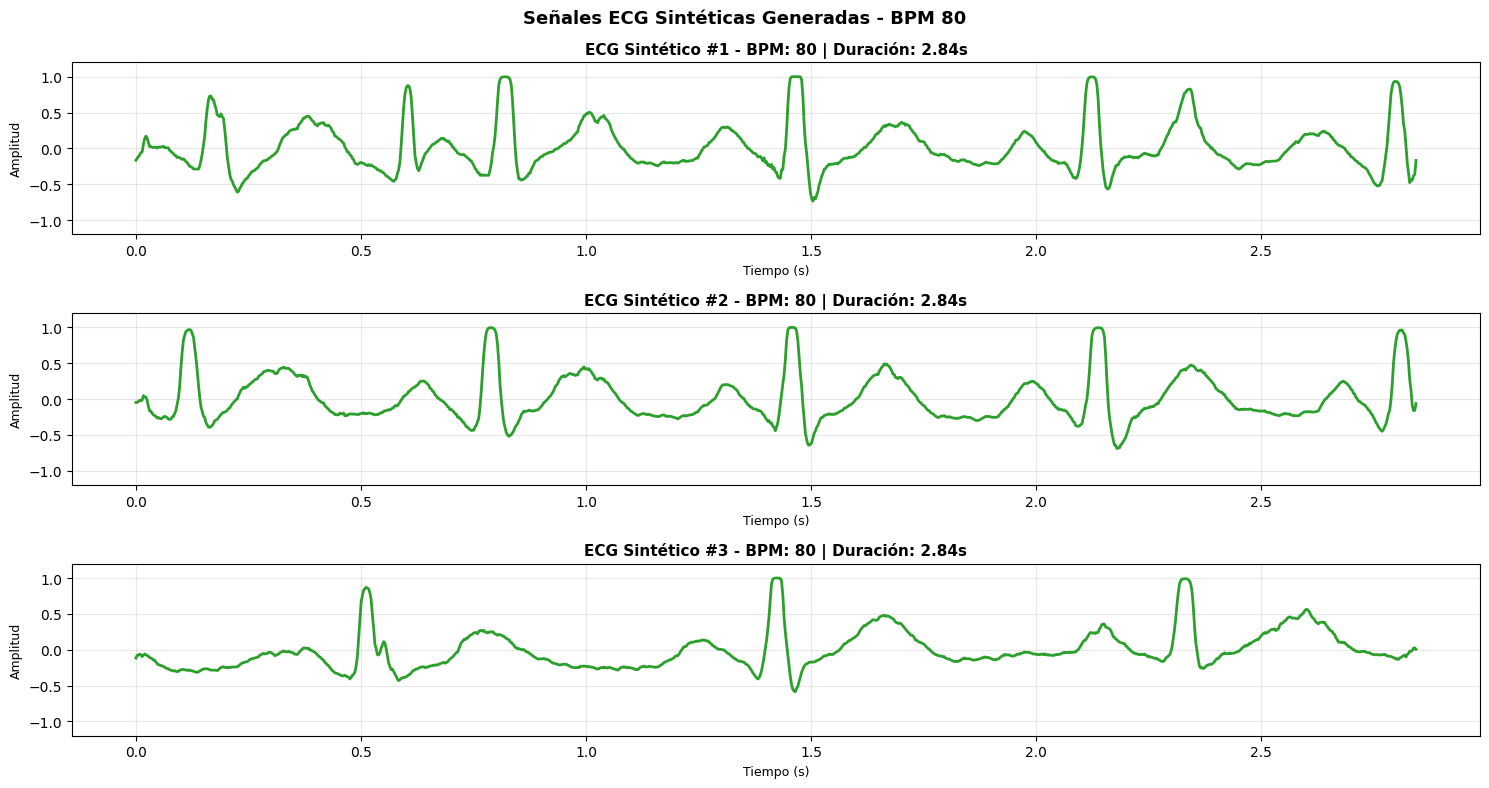


✓ Generación completada
  Shape de salida: (3, 1024)
  Duración por señal: 2.84 segundos
  Frecuencia de muestreo: 360 Hz
  Total de muestras por señal: 1024


In [34]:
# Ejemplo: Generar ECG con BPM=80
print("="*80)
print("GENERACIÓN DE ECG SINTÉTICO A PARTIR DE BPM")
print("="*80)

target_bpm = 80
num_signals = 3

print(f"\nGenerando {num_signals} señales ECG con BPM={target_bpm}")
synthetic_ecgs = generate_synthetic_ecg(target_bpm, num_samples=num_signals, seed=42)

# Visualizar las señales generadas
fig, axes = plt.subplots(num_signals, 1, figsize=(15, 8))
if num_signals == 1:
    axes = [axes]

time_axis = np.linspace(0, L/FS, L)

for i, ecg in enumerate(synthetic_ecgs):
    axes[i].plot(time_axis, ecg, linewidth=2, color='#2ca02c')
    axes[i].set_title(f'ECG Sintético #{i+1} - BPM: {target_bpm} | Duración: {L/FS:.2f}s', 
                     fontsize=11, fontweight='bold')
    axes[i].set_xlabel('Tiempo (s)', fontsize=9)
    axes[i].set_ylabel('Amplitud', fontsize=9)
    axes[i].grid(True, alpha=0.3)
    axes[i].set_ylim(-1.2, 1.2)

plt.suptitle(f'Señales ECG Sintéticas Generadas - BPM {target_bpm}', 
             fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"\n✓ Generación completada")
print(f"  Shape de salida: {synthetic_ecgs.shape}")
print(f"  Duración por señal: {L/FS:.2f} segundos")
print(f"  Frecuencia de muestreo: {FS} Hz")
print(f"  Total de muestras por señal: {L}")
print("="*80)

GENERACIÓN DE ECG SINTÉTICO A PARTIR DE BPM

Generando 3 señales ECG con BPM=110


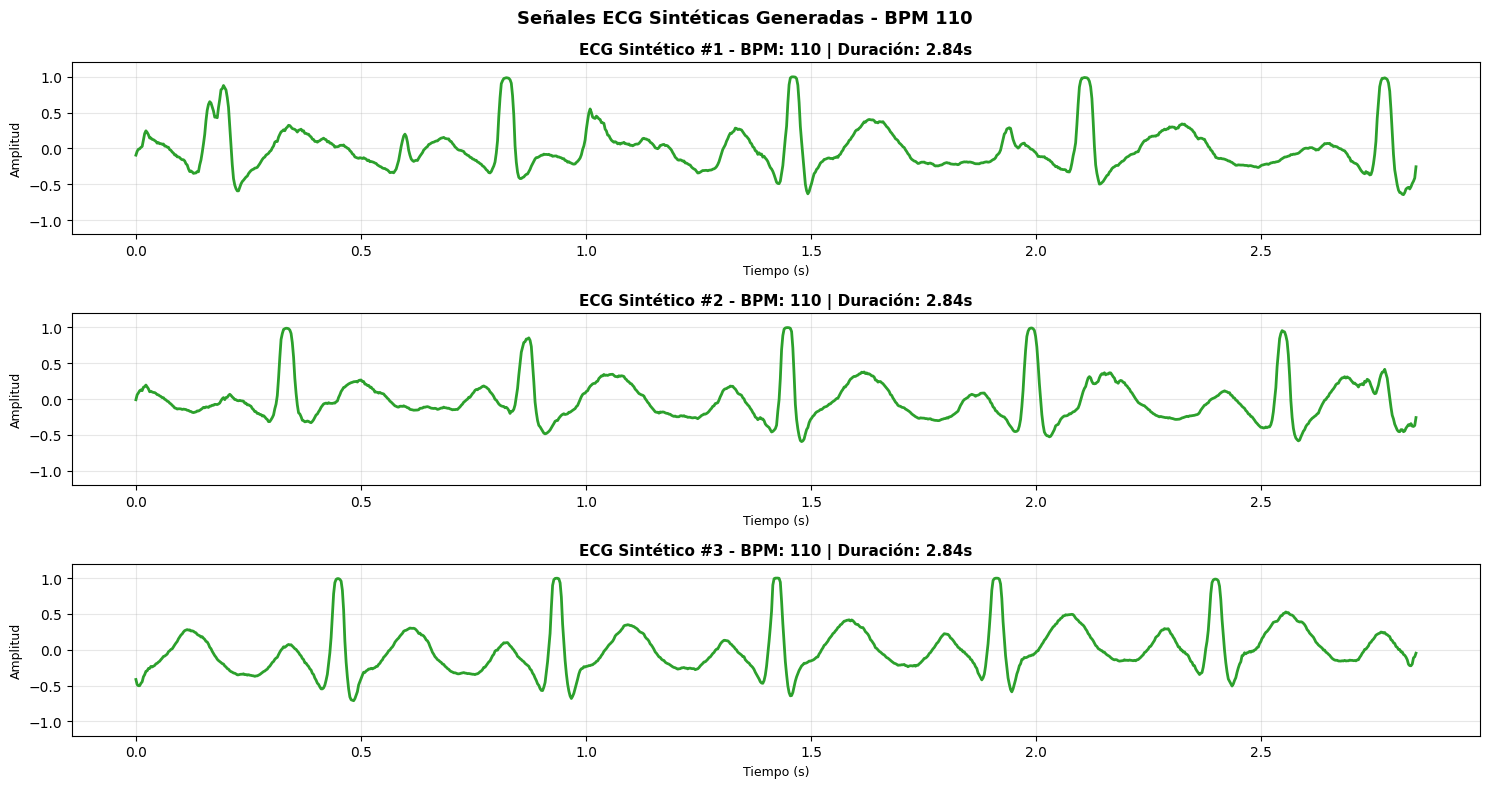


✓ Generación completada
  Shape de salida: (3, 1024)
  Duración por señal: 2.84 segundos
  Frecuencia de muestreo: 360 Hz
  Total de muestras por señal: 1024


In [35]:
# Ejemplo: Generar ECG con BPM=80
print("="*80)
print("GENERACIÓN DE ECG SINTÉTICO A PARTIR DE BPM")
print("="*80)

target_bpm = 110
num_signals = 3

print(f"\nGenerando {num_signals} señales ECG con BPM={target_bpm}")
synthetic_ecgs = generate_synthetic_ecg(target_bpm, num_samples=num_signals, seed=42)

# Visualizar las señales generadas
fig, axes = plt.subplots(num_signals, 1, figsize=(15, 8))
if num_signals == 1:
    axes = [axes]

time_axis = np.linspace(0, L/FS, L)

for i, ecg in enumerate(synthetic_ecgs):
    axes[i].plot(time_axis, ecg, linewidth=2, color='#2ca02c')
    axes[i].set_title(f'ECG Sintético #{i+1} - BPM: {target_bpm} | Duración: {L/FS:.2f}s', 
                     fontsize=11, fontweight='bold')
    axes[i].set_xlabel('Tiempo (s)', fontsize=9)
    axes[i].set_ylabel('Amplitud', fontsize=9)
    axes[i].grid(True, alpha=0.3)
    axes[i].set_ylim(-1.2, 1.2)

plt.suptitle(f'Señales ECG Sintéticas Generadas - BPM {target_bpm}', 
             fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"\n✓ Generación completada")
print(f"  Shape de salida: {synthetic_ecgs.shape}")
print(f"  Duración por señal: {L/FS:.2f} segundos")
print(f"  Frecuencia de muestreo: {FS} Hz")
print(f"  Total de muestras por señal: {L}")
print("="*80)

GENERACIÓN DE ECG SINTÉTICO A PARTIR DE BPM

Generando 3 señales ECG con BPM=105


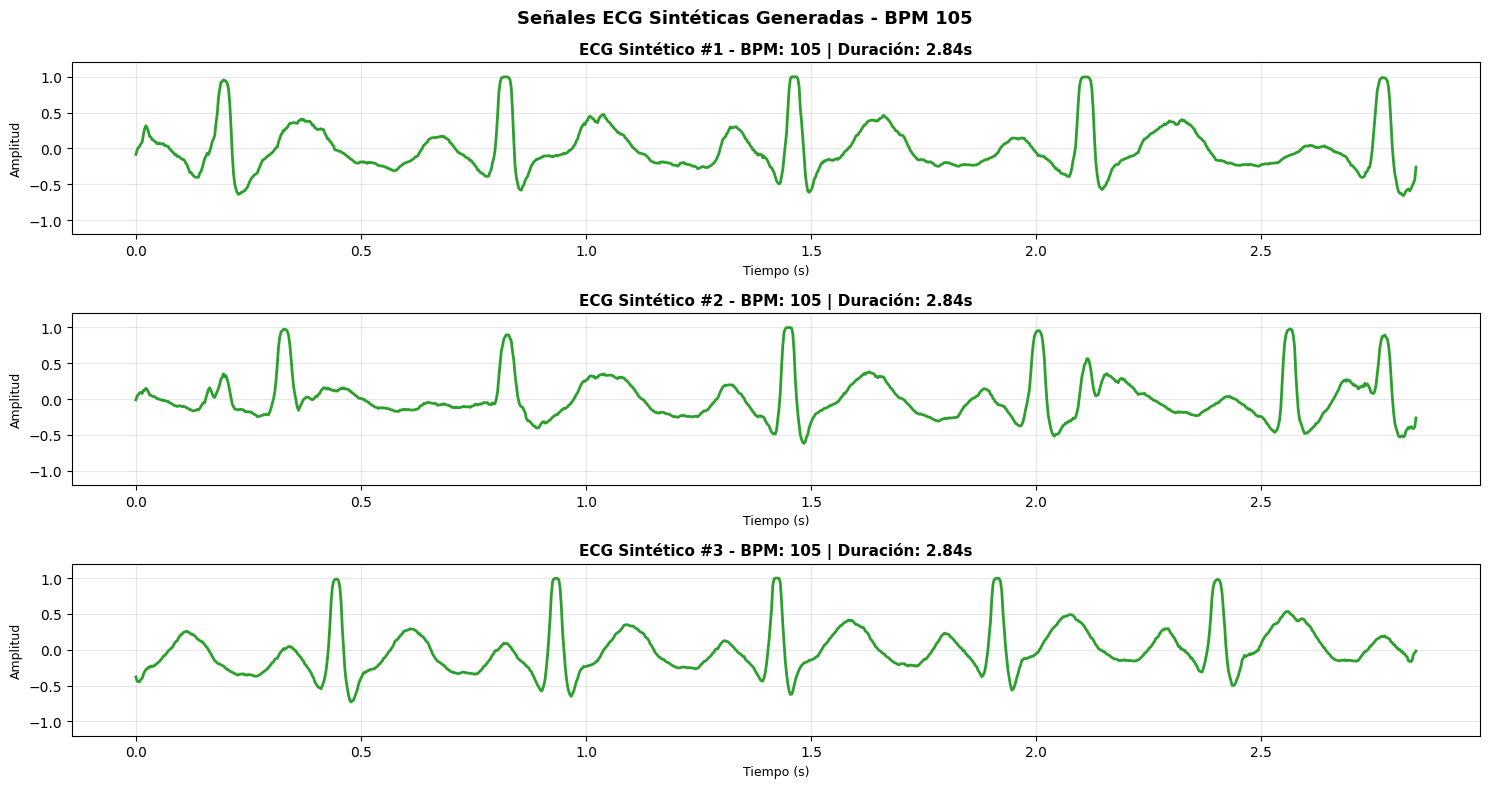


✓ Generación completada
  Shape de salida: (3, 1024)
  Duración por señal: 2.84 segundos
  Frecuencia de muestreo: 360 Hz
  Total de muestras por señal: 1024


In [36]:
# Ejemplo: Generar ECG con BPM=80
print("="*80)
print("GENERACIÓN DE ECG SINTÉTICO A PARTIR DE BPM")
print("="*80)

target_bpm = 105
num_signals = 3

print(f"\nGenerando {num_signals} señales ECG con BPM={target_bpm}")
synthetic_ecgs = generate_synthetic_ecg(target_bpm, num_samples=num_signals, seed=42)

# Visualizar las señales generadas
fig, axes = plt.subplots(num_signals, 1, figsize=(15, 8))
if num_signals == 1:
    axes = [axes]

time_axis = np.linspace(0, L/FS, L)

for i, ecg in enumerate(synthetic_ecgs):
    axes[i].plot(time_axis, ecg, linewidth=2, color='#2ca02c')
    axes[i].set_title(f'ECG Sintético #{i+1} - BPM: {target_bpm} | Duración: {L/FS:.2f}s', 
                     fontsize=11, fontweight='bold')
    axes[i].set_xlabel('Tiempo (s)', fontsize=9)
    axes[i].set_ylabel('Amplitud', fontsize=9)
    axes[i].grid(True, alpha=0.3)
    axes[i].set_ylim(-1.2, 1.2)

plt.suptitle(f'Señales ECG Sintéticas Generadas - BPM {target_bpm}', 
             fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"\n✓ Generación completada")
print(f"  Shape de salida: {synthetic_ecgs.shape}")
print(f"  Duración por señal: {L/FS:.2f} segundos")
print(f"  Frecuencia de muestreo: {FS} Hz")
print(f"  Total de muestras por señal: {L}")
print("="*80)